# Import our libraries

In [11]:
# ===============================
# Data handling
# ===============================
import pandas as pd
import numpy as np

# ===============================
# Data preprocessing & sampling
# ===============================
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# ===============================
# Models - Classification
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# ===============================
# Model selection & tuning
# ===============================
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, learning_curve, cross_val_score

# ===============================
# Metrics - Classification
# ===============================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    RocCurveDisplay, precision_recall_curve, auc
)

# ===============================
# Metrics - Regression
# ===============================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===============================
# Statistical tests
# ===============================
from scipy.stats import ttest_rel, wilcoxon
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# ===============================
# Visualization
# ===============================
import matplotlib.pyplot as plt
import shap

# ===============================
# Google Colab drive
# ===============================
from google.colab import drive
pd.set_option("display.max_columns", 200)
pd.set_option("display.float_format", "{:.3f}".format)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# import data from drive

In [12]:
import pandas as pd
import glob
import os
path = '/content/drive/MyDrive/ML data/*.csv'
files = glob.glob(path)

data = {}

for f in files:
    name = os.path.splitext(os.path.basename(f))[0]
    data[name] = pd.read_csv(f)

In [13]:
print(data.keys())

dict_keys(['aisles', 'departments', 'order_products__train', 'order_products__prior', 'products', 'orders', 'orders_products_full'])


In [14]:
aisles_df = data['aisles']
departments_df = data['departments']
order_products__train_df = data['order_products__train']
order_products__prior_df = data['order_products__prior']
products_df = data['products']
orders_df = data['orders']

### some basic EDA to explore our tables

In [15]:
aisles_df.info()
departments_df.info()
products_df.info()
orders_df.info()
order_products__prior_df.info()
order_products__train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 

### Specifying column data types

In [16]:
aisles_df = aisles_df.astype({
    "aisle_id": "int16",
    "aisle": "category"
})

departments_df = departments_df.astype({
    "department_id": "int16",
    "department": "category"
})

products_df = products_df.astype({
    "product_id": "int32",
    "aisle_id": "int16",
    "department_id": "int16",
    "product_name": "category"
})

orders_df = orders_df.astype({
    "order_id": "int32",
    "user_id": "int32",
    "eval_set": "category",
    "order_number": "int16",
    "order_dow": "int8",
    "order_hour_of_day": "int8"
})

order_products__prior_df = order_products__prior_df.astype({
    "order_id": "int32",
    "product_id": "int32",
    "add_to_cart_order": "int16",
    "reordered": "int8"
})

order_products__train_df = order_products__train_df.astype({
    "order_id": "int32",
    "product_id": "int32",
    "add_to_cart_order": "int16",
    "reordered": "int8"
})


In [17]:
aisles_df.info()
departments_df.info()
products_df.info()
orders_df.info()
order_products__prior_df.info()
order_products__train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   aisle_id  134 non-null    int16   
 1   aisle     134 non-null    category
dtypes: category(1), int16(1)
memory usage: 5.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   department_id  21 non-null     int16   
 1   department     21 non-null     category
dtypes: category(1), int16(1)
memory usage: 919.0 bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   product_id     49688 non-null  int32   
 1   product_name   49688 non-null  category
 2   aisle_id       49688 non-null  int16   
 3   departmen

### Merge and integrate the data

In [ ]:
products_full_df = (
    products_df
    .merge(aisles_df, on="aisle_id", how="left")
    .merge(departments_df, on="department_id", how="left")
)



,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages


In [ ]:
prior_full_df = (
    order_products__prior_df
    .merge(orders_df, on="order_id", how="left")
    .merge(products_full_df, on="product_id", how="left")
)

prior_full_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int16   
 3   reordered               int8    
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int16   
 7   order_dow               int8    
 8   order_hour_of_day       int8    
 9   days_since_prior_order  float64 
 10  product_name            category
 11  aisle_id                int16   
 12  department_id           int16   
 13  aisle                   category
 14  department              category
dtypes: category(4), float64(1), int16(4), int32(3), int8(3)
memory usage: 1.2 GB


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.000,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.000,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.000,Garlic Powder,104,13,spices seasonings,pantry


In [ ]:
train_full_df = (
    order_products__train_df
    .merge(orders_df, on="order_id", how="left")
    .merge(products_full_df, on="product_id", how="left")
)

train_full_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   order_id                1384617 non-null  int32   
 1   product_id              1384617 non-null  int32   
 2   add_to_cart_order       1384617 non-null  int16   
 3   reordered               1384617 non-null  int8    
 4   user_id                 1384617 non-null  int32   
 5   eval_set                1384617 non-null  category
 6   order_number            1384617 non-null  int16   
 7   order_dow               1384617 non-null  int8    
 8   order_hour_of_day       1384617 non-null  int8    
 9   days_since_prior_order  1384617 non-null  float64 
 10  product_name            1384617 non-null  category
 11  aisle_id                1384617 non-null  int16   
 12  department_id           1384617 non-null  int16   
 13  aisle                   1384617 non-null  

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.000,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.000,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.000,Organic Celery Hearts,83,4,fresh vegetables,produce


### check if we have any missing values

In [21]:
import pandas as pd

datasets = {
    "Prior Orders": prior_full_df,
    "Train Orders": train_full_df,
    "Products": products_full_df
}

for name, df in datasets.items():
    print(f"\n--- Missing Values in {name} ---")
    missing = df.isna().mean().sort_values(ascending=False)
    print(missing)



--- Missing Values in Prior Orders ---
days_since_prior_order   0.064
product_id               0.000
order_id                 0.000
reordered                0.000
user_id                  0.000
eval_set                 0.000
add_to_cart_order        0.000
order_number             0.000
order_dow                0.000
order_hour_of_day        0.000
product_name             0.000
aisle_id                 0.000
department_id            0.000
aisle                    0.000
department               0.000
dtype: float64

--- Missing Values in Train Orders ---
order_id                 0.000
product_id               0.000
add_to_cart_order        0.000
reordered                0.000
user_id                  0.000
eval_set                 0.000
order_number             0.000
order_dow                0.000
order_hour_of_day        0.000
days_since_prior_order   0.000
product_name             0.000
aisle_id                 0.000
department_id            0.000
aisle                    0.000
depart

### make our tables(dataframes) in one dataframe by merging

In [22]:
orders_products_full = pd.concat(
    [train_full_df, prior_full_df],
    axis=0,
    ignore_index=True
)

In [23]:
orders_products_full = orders_products_full.sample(frac=0.04, random_state=42)

In [24]:
orders_products_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1352764 entries, 7009614 to 7263318
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   order_id                1352764 non-null  int32   
 1   product_id              1352764 non-null  int32   
 2   add_to_cart_order       1352764 non-null  int16   
 3   reordered               1352764 non-null  int8    
 4   user_id                 1352764 non-null  int32   
 5   eval_set                1352764 non-null  category
 6   order_number            1352764 non-null  int16   
 7   order_dow               1352764 non-null  int8    
 8   order_hour_of_day       1352764 non-null  int8    
 9   days_since_prior_order  1269604 non-null  float64 
 10  product_name            1352764 non-null  category
 11  aisle_id                1352764 non-null  int16   
 12  department_id           1352764 non-null  int16   
 13  aisle                   1352764 non-null 

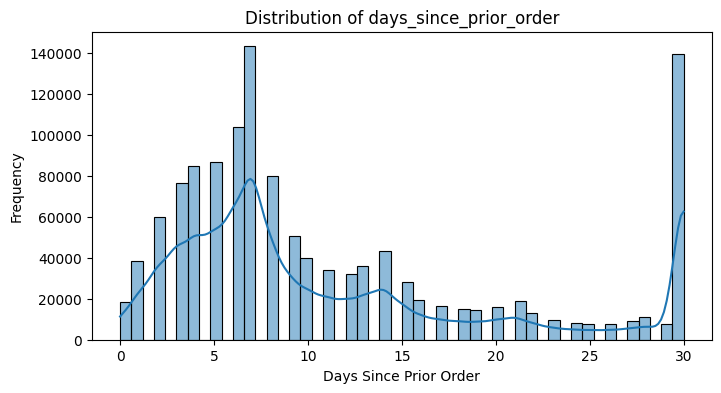

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

days = orders_products_full["days_since_prior_order"].dropna()

plt.figure(figsize=(8,4))
sns.histplot(days, bins=50, kde=True)
plt.title("Distribution of days_since_prior_order")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Frequency")
plt.show()


### plot the columns that have missing values like(days since prior order)

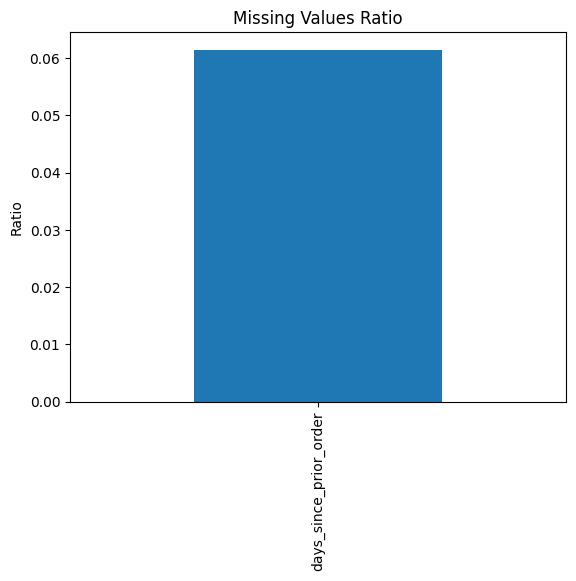

In [26]:
missing_ratio = orders_products_full.isna().mean().sort_values(ascending=False)

missing_ratio[missing_ratio > 0].plot(
    kind="bar",
    title="Missing Values Ratio"
)
plt.ylabel("Ratio")
plt.show()


In [27]:
orders_products_full['days_since_prior_order'].isna().mean()

np.float64(0.061474137395732)

### fill the missing values by median

In [28]:
median_days = orders_products_full["days_since_prior_order"].median()
orders_products_full["days_since_prior_order"].fillna(median_days, inplace=True)
print(orders_products_full['days_since_prior_order'].isna().mean())

0.0


/tmp/ipython-input-3748730946.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_products_full["days_since_prior_order"].fillna(median_days, inplace=True)


### EDA to explore the distribution of the columns

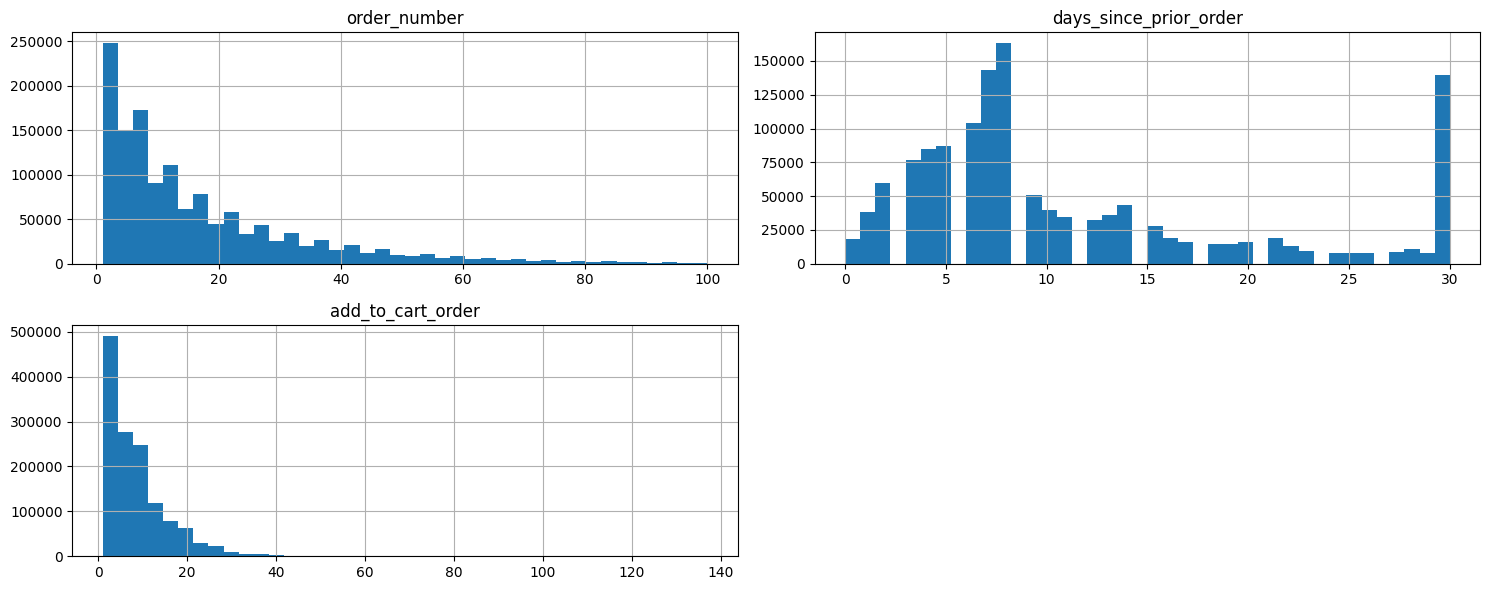

In [29]:
numeric_cols = ["order_number","days_since_prior_order", "add_to_cart_order"]

orders_products_full[numeric_cols].hist(bins=40, figsize=(15,6))
plt.tight_layout()
plt.show()


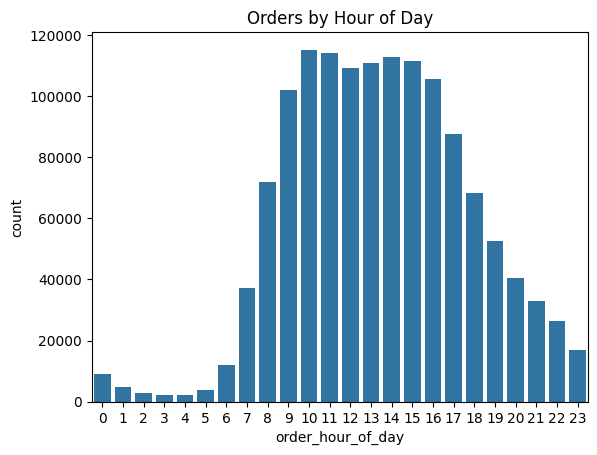

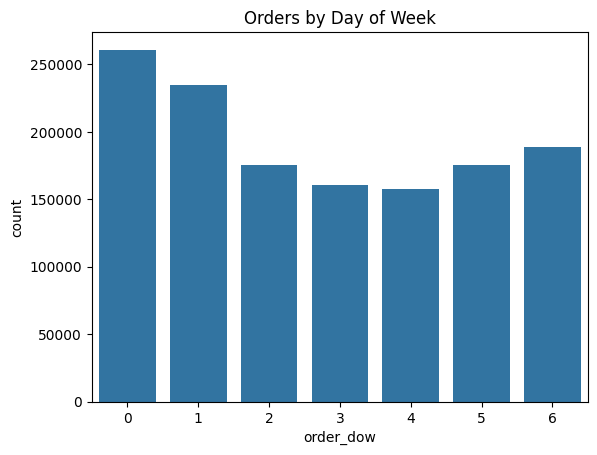

In [30]:
sns.countplot(x="order_hour_of_day", data=orders_products_full)
plt.title("Orders by Hour of Day")
plt.show()

sns.countplot(x="order_dow", data=orders_products_full)
plt.title("Orders by Day of Week")
plt.show()



Top 10 frequent values in aisle:
aisle
fresh fruits                     151891
fresh vegetables                 142611
packaged vegetables fruits        74058
yogurt                            60164
packaged cheese                   41001
milk                              36923
water seltzer sparkling water     35323
chips pretzels                    30111
soy lactosefree                   26519
bread                             24410
Name: count, dtype: int64


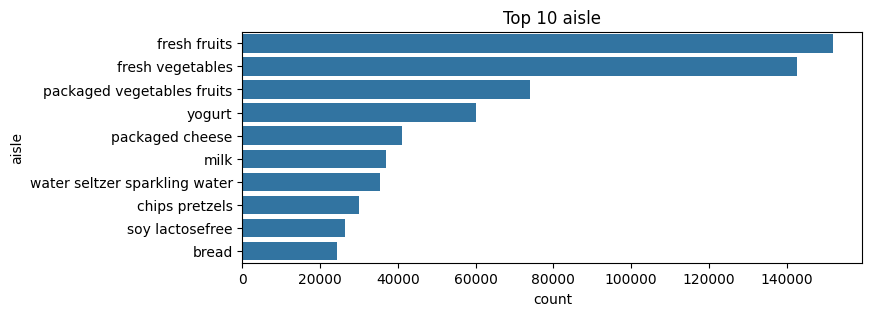


Top 10 frequent values in department:
department
produce            395924
dairy eggs         225163
snacks             120733
beverages          112368
frozen              93616
pantry              77638
bakery              49028
canned goods        44371
deli                43856
dry goods pasta     36105
Name: count, dtype: int64


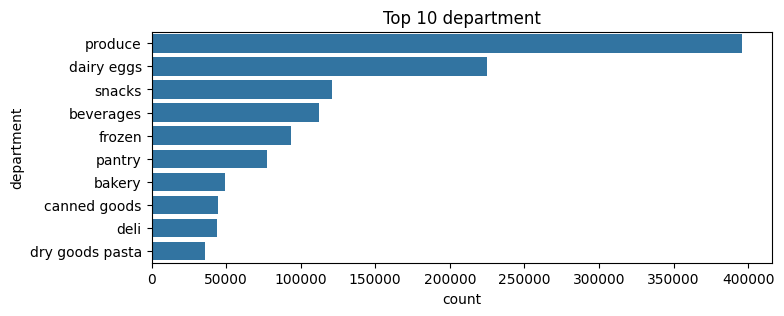


Top 10 frequent values in product_name:
product_name
Banana                    19460
Bag of Organic Bananas    15752
Organic Strawberries      11046
Organic Baby Spinach      10111
Organic Hass Avocado       8735
Organic Avocado            7369
Large Lemon                6452
Strawberries               5995
Limes                      5869
Organic Whole Milk         5782
Name: count, dtype: int64


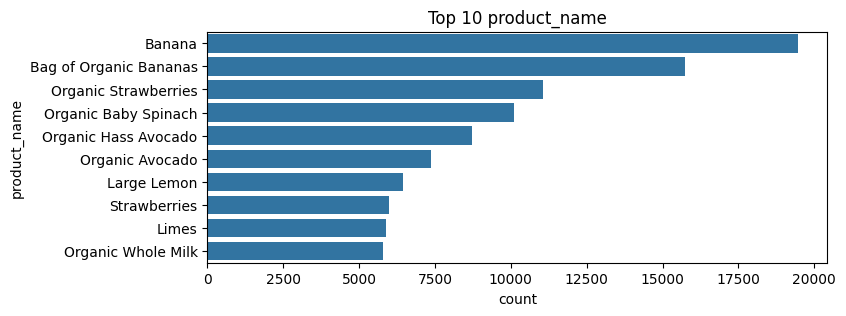

In [31]:
cat_cols = ["aisle", "department", "product_name"]

for col in cat_cols:
    print(f"\nTop 10 frequent values in {col}:")
    print(orders_products_full[col].value_counts().head(10))

    plt.figure(figsize=(8,3))
    sns.countplot(y=col, data=orders_products_full, order=orders_products_full[col].value_counts().index[:10])
    plt.title(f"Top 10 {col}")
    plt.show()


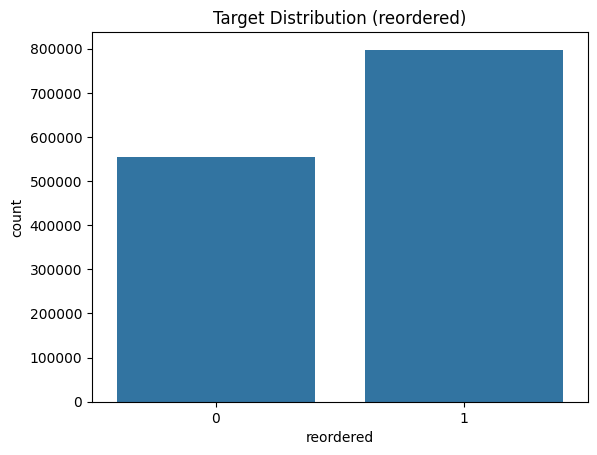

In [32]:
sns.countplot(x="reordered", data=orders_products_full)
plt.title("Target Distribution (reordered)")
plt.show()


### Correlation matrix between the columns

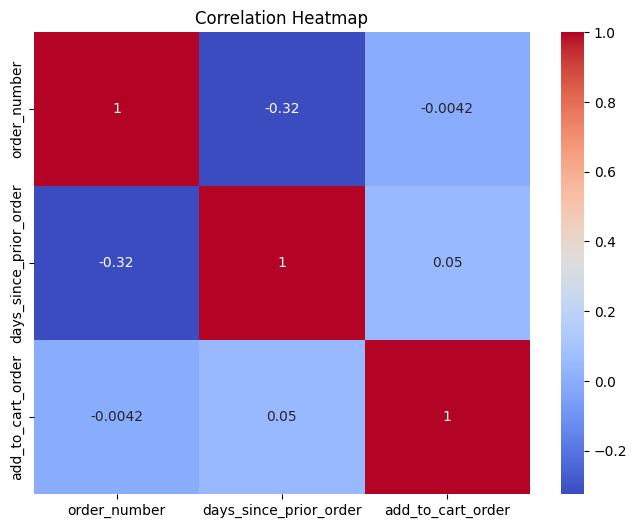

In [33]:
corr = orders_products_full[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

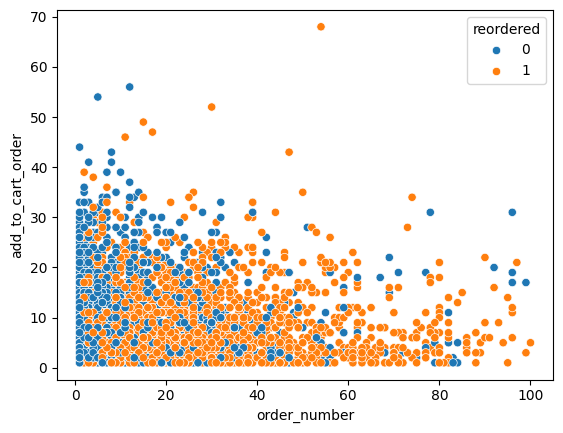

In [34]:
sns.scatterplot(
    x="order_number",
    y="add_to_cart_order",
    hue="reordered",
    data=orders_products_full.sample(5000, random_state=42)
)
plt.show()


In [35]:
numeric_cols = [
    "days_since_prior_order",
    "add_to_cart_order",
    "order_number",
    "order_hour_of_day",
    "order_dow"
]

categorical_cols = [
    "department",
    "aisle",
    "product_name"
]


### detect outliers and apply winsorization method

In [36]:
col = "order_number"

print("Before Winsorization:")
print(orders_products_full[col].describe())

Q1 = orders_products_full[col].quantile(0.25)
Q3 = orders_products_full[col].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 3 * IQR
upper = Q3 + 3 * IQR
orders_products_full[col] = orders_products_full[col].clip(lower, upper)

print("After Winsorization:")
print(orders_products_full[col].describe())


Before Winsorization:
count   1352764.000
mean         17.101
std          17.462
min           1.000
25%           5.000
50%          11.000
75%          24.000
max         100.000
Name: order_number, dtype: float64
After Winsorization:
count   1352764.000
mean         17.016
std          17.120
min           1.000
25%           5.000
50%          11.000
75%          24.000
max          81.000
Name: order_number, dtype: float64


In [37]:
col = "add_to_cart_order"

print("Before Winsorization:")
print(orders_products_full[col].describe())

Q1 = orders_products_full[col].quantile(0.25)
Q3 = orders_products_full[col].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 10 * IQR
upper = Q3 + 10 * IQR
orders_products_full[col] = orders_products_full[col].clip(lower, upper)

print("After Winsorization:")
print(orders_products_full[col].describe())


Before Winsorization:
count   1352764.000
mean          8.371
std           7.130
min           1.000
25%           3.000
50%           6.000
75%          11.000
max         137.000
Name: add_to_cart_order, dtype: float64
After Winsorization:
count   1352764.000
mean          8.370
std           7.126
min           1.000
25%           3.000
50%           6.000
75%          11.000
max          91.000
Name: add_to_cart_order, dtype: float64


### Feature engineerig by creating some features

In [38]:
import numpy as np
import pandas as pd

# -----------------------------
# 1) User-level Features
# -----------------------------
user_features = orders_products_full.groupby("user_id").agg(
    total_orders=("order_number", "max"),
    avg_basket_size=("add_to_cart_order", lambda x: x.count() / orders_products_full.loc[x.index, "order_id"].nunique())
).reset_index()
orders_products_full = orders_products_full.merge(user_features, on='user_id', how='left')
orders_products_full = orders_products_full.sort_values(['user_id','order_number'])

orders_products_full['reorder_ratio'] = (
    orders_products_full
    .groupby('user_id')['reordered']
    .transform(lambda x: x.shift().expanding().mean())
)


In [39]:
# -----------------------------
# 2) Product-level Features
# -----------------------------
product_features = orders_products_full.groupby("product_id").agg(
    overall_reorder_rate=("reordered", "mean"),
    avg_cart_position=("add_to_cart_order", "mean")
).reset_index()

orders_products_full = orders_products_full.merge(product_features, on='product_id', how='left')


In [40]:
# -----------------------------
# 3) User × Product Features
# -----------------------------
orders_products_full = orders_products_full.sort_values(
    ['user_id','product_id','order_number']
)

orders_products_full['prior_purchase_count'] = (
    orders_products_full
    .groupby(['user_id','product_id'])
    .cumcount()
)

orders_products_full['avg_reorder_probability_user_product'] = (
    orders_products_full
    .groupby(['user_id','product_id'])['reordered']
    .transform(lambda x: x.shift().expanding().mean())
)


In [41]:
# -----------------------------
# 4) Temporal Features
# -----------------------------
orders_products_full['order_hour'] = orders_products_full['order_hour_of_day']
orders_products_full['order_day'] = orders_products_full['order_dow']


In [42]:
# -----------------------------
# 5) Rolling / Window Feature
# -----------------------------
orders_products_full = orders_products_full.sort_values(['user_id','order_number'])
orders_products_full['last_3_orders_mean'] = (
    orders_products_full
    .groupby('user_id')['reordered']
    .transform(lambda x: x.shift().rolling(3, min_periods=1).mean())
)


In [43]:
# -----------------------------
# 6) Engineered Non-linear Feature
# -----------------------------
orders_products_full['log_interaction'] = np.log1p(
    orders_products_full['avg_basket_size'] * orders_products_full['overall_reorder_rate']
)

print(orders_products_full.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1352764 entries, 0 to 1352763
Data columns (total 26 columns):
 #   Column                                Non-Null Count    Dtype   
---  ------                                --------------    -----   
 0   order_id                              1352764 non-null  int32   
 1   product_id                            1352764 non-null  int32   
 2   add_to_cart_order                     1352764 non-null  int16   
 3   reordered                             1352764 non-null  int8    
 4   user_id                               1352764 non-null  int32   
 5   eval_set                              1352764 non-null  category
 6   order_number                          1352764 non-null  int16   
 7   order_dow                             1352764 non-null  int8    
 8   order_hour_of_day                     1352764 non-null  int8    
 9   days_since_prior_order                1352764 non-null  float64 
 10  product_name                          1352764 n

### explore missing values after creating some new features

In [44]:
orders_products_full.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0


### fill missing values that have appeared when we make feature engineering

In [45]:
orders_products_full['reorder_ratio'] = (
    orders_products_full['reorder_ratio'].fillna(0)
)
orders_products_full['last_3_orders_mean'] = (
    orders_products_full['last_3_orders_mean'].fillna(0)
)
orders_products_full['avg_reorder_probability_user_product'] = (
    orders_products_full['avg_reorder_probability_user_product'].fillna(0)
)


In [46]:
orders_products_full.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0


### correlation matrix on whole data set

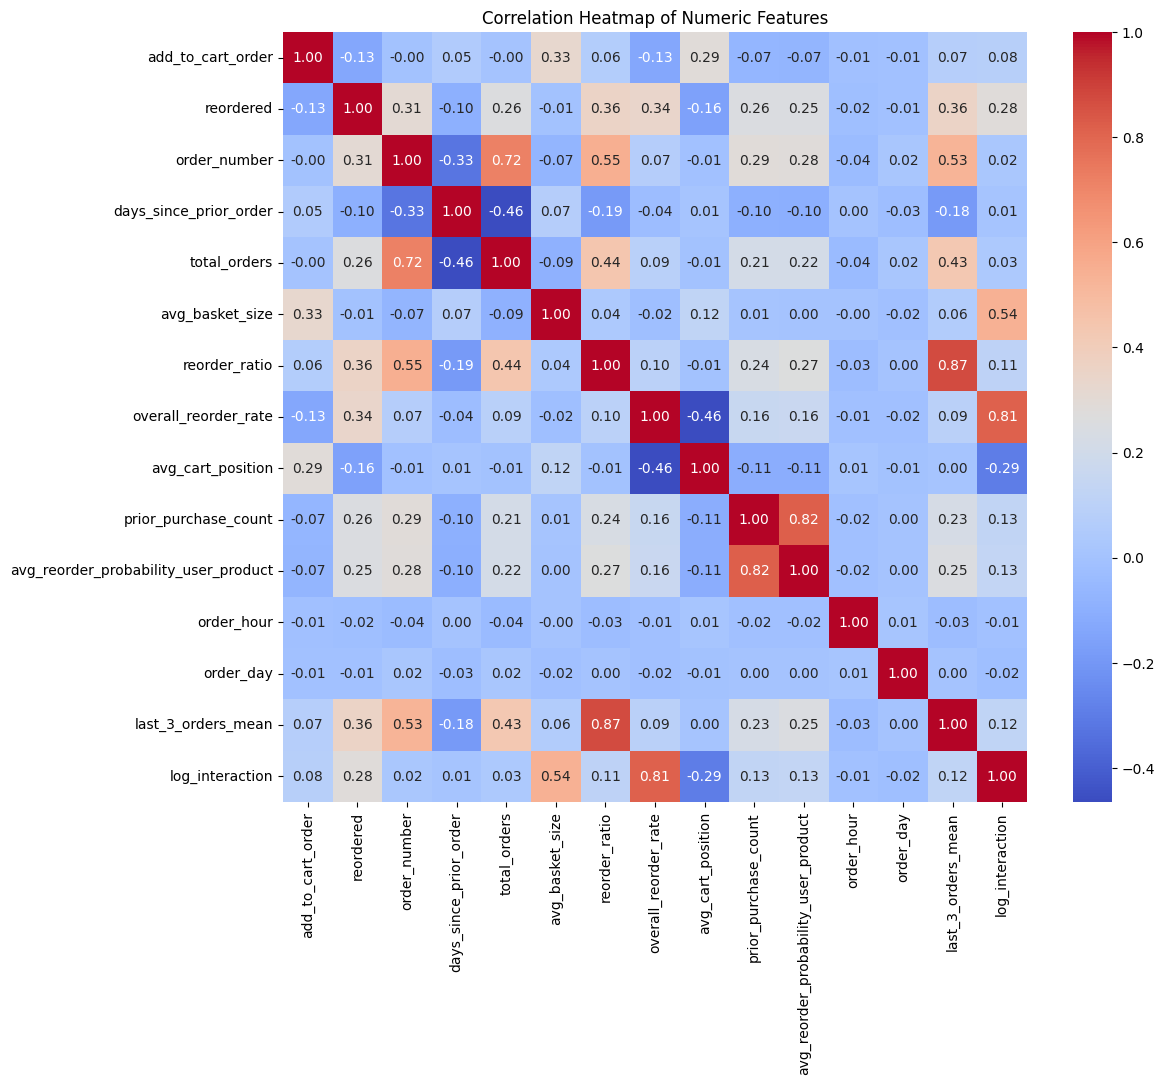

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    'add_to_cart_order', 'reordered', 'order_number',
    'days_since_prior_order', 'total_orders', 'avg_basket_size',
    'reorder_ratio', 'overall_reorder_rate', 'avg_cart_position',
    'prior_purchase_count', 'avg_reorder_probability_user_product',
    'order_hour', 'order_day', 'last_3_orders_mean', 'log_interaction'
]

numeric_df = orders_products_full[numeric_cols].fillna(0)

corr = numeric_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


### save the new cleaned dataset on drive

In [48]:
orders_products_full.to_csv("orders_products_full.csv", index=False)

In [49]:
orders_products_full.to_csv("/content/drive/MyDrive/ML data/orders_products_full.csv", index=False)


### read our data set that we have saved

In [50]:
file_path = '/content/drive/MyDrive/ML data/orders_products_full.csv'
orders_full = pd.read_csv(file_path)

In [51]:
df = orders_full.copy()

### explore the imbalance on the target colummn

In [52]:
print("Distribution of 'reordered':")
print(df['reordered'].value_counts())
print(df['reordered'].value_counts(normalize=True))

Distribution of 'reordered':
reordered
1    797790
0    554974
Name: count, dtype: int64
reordered
1   0.590
0   0.410
Name: proportion, dtype: float64


### drop eval set column

In [53]:
if 'eval_set' in df.columns:
    df = df.drop('eval_set', axis=1)

### make encoding on categorical columns

In [54]:
one_hot_cols = ['aisle', 'department']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

### split our data to two data sets(training and testing dataset)

In [55]:
threshold = df['order_number'].quantile(0.8)
train = df[df['order_number'] <= threshold].copy()
val   = df[df['order_number'] > threshold].copy()


### make encoding on product name column to help us in prediction models

In [56]:
product_mean = train.groupby('product_name')['reordered'].mean()

train['product_name_mean_enc'] = train['product_name'].map(product_mean)
val['product_name_mean_enc']   = val['product_name'].map(product_mean)


### drop missing values that generated when we make the product name column encoding

In [57]:
train = train.dropna(subset=['product_name_mean_enc'])
val   = val.dropna(subset=['product_name_mean_enc'])

In [58]:
missing_train = train.isna().sum().sort_values(ascending=False)
missing_val   = val.isna().sum().sort_values(ascending=False)

print("=== Missing values in X_train ===")
print(missing_train[missing_train > 0])

print("\n=== Missing values in X_val ===")
print(missing_val[missing_val > 0])


=== Missing values in X_train ===
Series([], dtype: int64)

=== Missing values in X_val ===
Series([], dtype: int64)


### drop product name feaure because we are encoded it

In [59]:
train.drop('product_name', axis=1, inplace=True)
val.drop('product_name', axis=1, inplace=True)


### prepare our train and validation data set

In [60]:
X_train = train.drop('reordered', axis=1)
y_train = train['reordered']

X_val = val.drop('reordered', axis=1)
y_val = val['reordered']


### smote on the training data set to solve the imbalance in target feature

In [74]:
MAX_TRAIN_SIZE = 400_000
MAX_VAL_SIZE = 50_000

X_train_small, y_train_small = shuffle(X_train, y_train, random_state=42)
if len(X_train_small) > MAX_TRAIN_SIZE:
    X_train_small = X_train_small.iloc[:MAX_TRAIN_SIZE]
    y_train_small = y_train_small.iloc[:MAX_TRAIN_SIZE]

X_val_small, y_val_small = shuffle(X_val, y_val, random_state=42)
if len(X_val_small) > MAX_VAL_SIZE:
    X_val_small = X_val_small.iloc[:MAX_VAL_SIZE]
    y_val_small = y_val_small.iloc[:MAX_VAL_SIZE]

print("Training size after truncation:", X_train_small.shape)
print("Validation size after truncation:", X_val_small.shape)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_small, y_train_small)

print("Resampled training size:", X_train_res.shape)

xgb_smote = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_smote.fit(X_train_res, y_train_res)

y_pred = xgb_smote.predict(X_val_small)
y_prob = xgb_smote.predict_proba(X_val_small)[:,1]
accuracy = accuracy_score(y_val_small, y_pred)
print("Accuracy:", accuracy)
precision, recall, _ = precision_recall_curve(y_val_small, y_prob)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


Training size after truncation: (400000, 170)
Validation size after truncation: (50000, 170)
Resampled training size: (400088, 170)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:35:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.81238
Precision-Recall AUC: 0.943471702988901


### scaling our numeric features to reduce the outliers effects using standard scaler

In [61]:
numeric_cols= [
    'add_to_cart_order',
    'days_since_prior_order',
    'total_orders',
    'avg_basket_size',
    'reorder_ratio',
    'overall_reorder_rate',
    'avg_cart_position',
    'prior_purchase_count',
    'avg_reorder_probability_user_product',
    'last_3_orders_mean',
    'log_interaction'
]


scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols]   = scaler.transform(X_val[numeric_cols])


sole imbalance using another technique (under sampling)

In [62]:
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)


### drop some features and take a sample from the whole data set

In [63]:
drop_cols = ['user_id', 'product_id', 'aisle_id', 'department_id',"order_id"]
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_val   = X_val.drop(columns=drop_cols, errors='ignore')

MAX_TRAIN_SIZE = 500000
MAX_VAL_SIZE   = 100000

if len(X_train) > MAX_TRAIN_SIZE:
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_train = X_train.iloc[:MAX_TRAIN_SIZE]
    y_train = y_train.iloc[:MAX_TRAIN_SIZE]

if len(X_val) > MAX_VAL_SIZE:
    X_val, y_val = shuffle(X_val, y_val, random_state=42)
    X_val = X_val.iloc[:MAX_VAL_SIZE]
    y_val = y_val.iloc[:MAX_VAL_SIZE]

print("Final train size:", X_train.shape)
print("Final validation size:", X_val.shape)


Final train size: (500000, 170)
Final validation size: (100000, 170)


### Starting to experiment with multiple models to identify the best one

Accuracy: 0.81092
Precision: 0.8146277895422708
Recall: 0.9913276178205065
F1 Score: 0.8943332960768973
Confusion Matrix:
 [[ 1076 18208]
 [  700 80016]]
ROC AUC: 0.7455461444177494


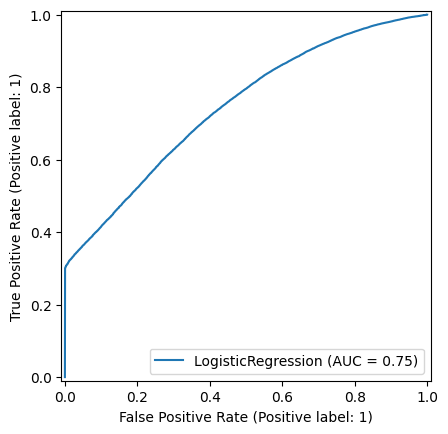

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
y_prob = lr.predict_proba(X_val)[:, 1]

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:\n", cm)

roc_auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", roc_auc)

RocCurveDisplay.from_estimator(lr, X_val, y_val)

### make feature selection because we have 180 columns

In [64]:
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=42)

xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_shuffled, y_train_shuffled)

importances = xgb_model.feature_importances_
feature_names = X_train.columns

sorted_idx = np.argsort(importances)[::-1]

print("Feature Importances (all features):")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

top_n = 10
selected_features = feature_names[sorted_idx][:top_n]

print("\nTop features (most important first):")
for f in selected_features:
    print(f)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:04:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Feature Importances (all features):
prior_purchase_count: 0.2147
avg_reorder_probability_user_product: 0.1879
order_number: 0.1605
product_name_mean_enc: 0.0844
reorder_ratio: 0.0549
last_3_orders_mean: 0.0471
overall_reorder_rate: 0.0365
add_to_cart_order: 0.0234
log_interaction: 0.0143
days_since_prior_order: 0.0096
total_orders: 0.0065
department_produce: 0.0031
avg_basket_size: 0.0031
department_missing: 0.0028
department_frozen: 0.0025
department_beverages: 0.0025
aisle_frozen meals: 0.0022
department_babies: 0.0022
aisle_frozen appetizers sides: 0.0022
aisle_fresh fruits: 0.0022
aisle_spices seasonings: 0.0020
aisle_butter: 0.0020
aisle_eggs: 0.0019
department_pantry: 0.0019
aisle_granola: 0.0019
department_snacks: 0.0019
department_household: 0.0019
aisle_cookies cakes: 0.0018
aisle_other creams cheeses: 0.0018
aisle_packaged produce: 0.0018
aisle_baby food formula: 0.0018
aisle_frozen meat seafood: 0.0018
department_dry goods pasta: 0.0017
aisle_pickled goods olives: 0.0017
ais

In [65]:
X_train_selected = X_train_shuffled[selected_features]
X_val_selected = X_val[selected_features]

=== Logistic Regression (L2) ===
              precision    recall  f1-score   support

           0       0.62      0.05      0.09     19284
           1       0.81      0.99      0.89     80716

    accuracy                           0.81    100000
   macro avg       0.72      0.52      0.49    100000
weighted avg       0.78      0.81      0.74    100000

ROC AUC: 0.7461588660661524


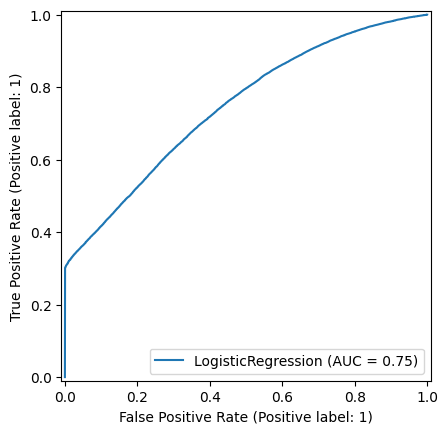

In [ ]:
lr_l2 = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2')
lr_l2.fit(X_train_selected, y_train_shuffled)
y_pred = lr_l2.predict(X_val_selected)
y_prob = lr_l2.predict_proba(X_val_selected)[:,1]

print("=== Logistic Regression (L2) ===")
print(classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_prob))
RocCurveDisplay.from_estimator(lr_l2, X_val_selected, y_val)

=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

           0       0.43      0.36      0.39     19284
           1       0.85      0.89      0.87     80716

    accuracy                           0.78    100000
   macro avg       0.64      0.62      0.63    100000
weighted avg       0.77      0.78      0.78    100000

ROC AUC: 0.7338924159625942


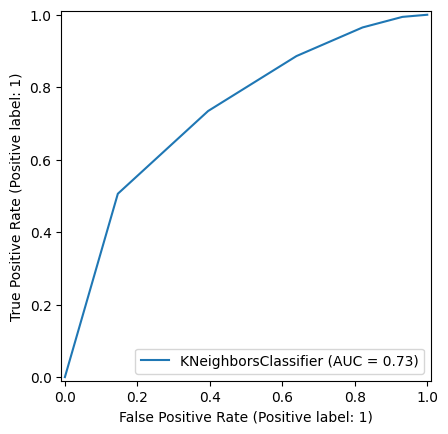

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_selected, y_train_shuffled)
y_pred = knn.predict(X_val_selected)
y_prob = knn.predict_proba(X_val_selected)[:,1]

print("=== K-Nearest Neighbors ===")
print(classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_prob))
RocCurveDisplay.from_estimator(knn, X_val_selected, y_val)

SVM train size: (10000, 10)
SVM val size: (2000, 10)
=== SVM Linear ===
              precision    recall  f1-score   support

           0       0.82      0.04      0.07       381
           1       0.81      1.00      0.90      1619

    accuracy                           0.81      2000
   macro avg       0.82      0.52      0.48      2000
weighted avg       0.82      0.81      0.74      2000

ROC AUC: 0.7396922049351614


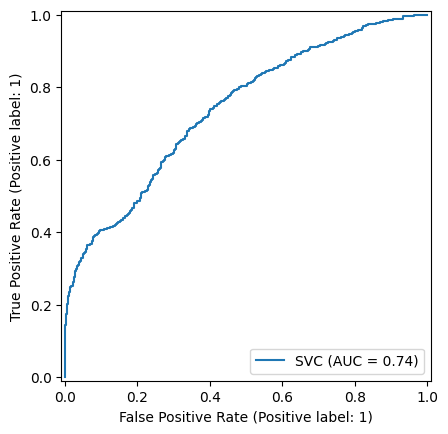

In [ ]:
MAX_SVM_TRAIN_SIZE = 10000
MAX_SVM_VAL_SIZE   = 2000

X_svm_train = X_train[selected_features].copy()
y_svm_train = y_train.copy()

X_svm_val = X_val[selected_features].copy()
y_svm_val = y_val.copy()

if len(X_svm_train) > MAX_SVM_TRAIN_SIZE:
    X_svm_train, y_svm_train = shuffle(X_svm_train, y_svm_train, random_state=42)
    X_svm_train = X_svm_train.iloc[:MAX_SVM_TRAIN_SIZE]
    y_svm_train = y_svm_train.iloc[:MAX_SVM_TRAIN_SIZE]

if len(X_svm_val) > MAX_SVM_VAL_SIZE:
    X_svm_val, y_svm_val = shuffle(X_svm_val, y_svm_val, random_state=42)
    X_svm_val = X_svm_val.iloc[:MAX_SVM_VAL_SIZE]
    y_svm_val = y_svm_val.iloc[:MAX_SVM_VAL_SIZE]

print("SVM train size:", X_svm_train.shape)
print("SVM val size:", X_svm_val.shape)

svm_linear = SVC(kernel='linear', class_weight='balanced', probability=True)
svm_linear.fit(X_svm_train, y_svm_train)

y_pred = svm_linear.predict(X_svm_val)
y_prob = svm_linear.predict_proba(X_svm_val)[:,1]

print("=== SVM Linear ===")
print(classification_report(y_svm_val, y_pred))
print("ROC AUC:", roc_auc_score(y_svm_val, y_prob))
RocCurveDisplay.from_estimator(svm_linear, X_svm_val, y_svm_val)


=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.45      0.32      0.37     19284
           1       0.85      0.91      0.88     80716

    accuracy                           0.79    100000
   macro avg       0.65      0.61      0.63    100000
weighted avg       0.77      0.79      0.78    100000

ROC AUC: 0.7526145139792674


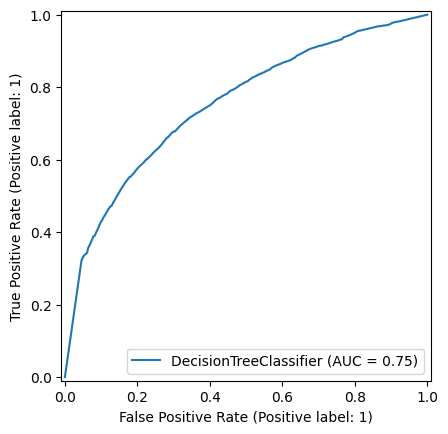

In [ ]:
dt = DecisionTreeClassifier(max_depth=15, class_weight='balanced', random_state=42)
dt.fit(X_train_selected, y_train_shuffled)
y_pred = dt.predict(X_val_selected)
y_prob = dt.predict_proba(X_val_selected)[:,1]

print("=== Decision Tree ===")
print(classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_prob))
RocCurveDisplay.from_estimator(dt, X_val_selected, y_val)

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.52      0.29      0.37     19284
           1       0.85      0.94      0.89     80716

    accuracy                           0.81    100000
   macro avg       0.68      0.61      0.63    100000
weighted avg       0.78      0.81      0.79    100000

ROC AUC: 0.791988137729754


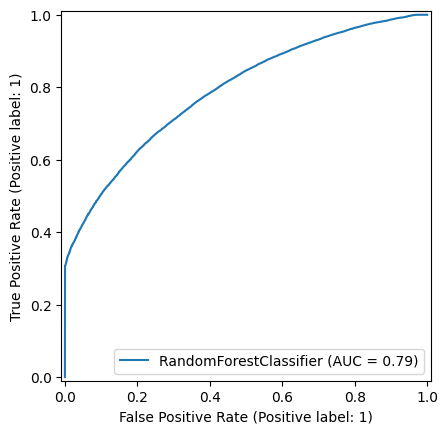

In [ ]:
rf= RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    max_features='sqrt',
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_selected, y_train_shuffled)
y_pred = rf.predict(X_val_selected)
y_prob = rf.predict_proba(X_val_selected)[:,1]

print("=== Random Forest ===")
print(classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_prob))
RocCurveDisplay.from_estimator(rf, X_val_selected, y_val)

### Baseline and tuned XGBoost classification with ROC AUC evaluation and hyperparameter tuning.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:36:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Before Tuning ===
              precision    recall  f1-score   support

           0       0.50      0.30      0.37     19284
           1       0.85      0.93      0.89     80716

    accuracy                           0.81    100000
   macro avg       0.67      0.61      0.63    100000
weighted avg       0.78      0.81      0.79    100000

ROC AUC: 0.78558401444954


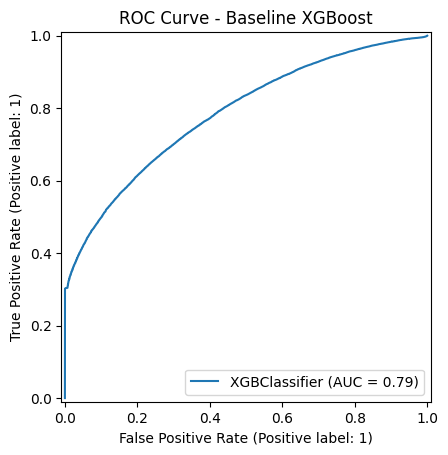

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:43:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGB params: {'subsample': 0.1, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.03, 'colsample_bytree': 0.8}
Best XGB ROC AUC (CV): 0.8380816962384934


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:44:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== After Tuning ===
              precision    recall  f1-score   support

           0       0.52      0.28      0.36     19284
           1       0.84      0.94      0.89     80716

    accuracy                           0.81    100000
   macro avg       0.68      0.61      0.63    100000
weighted avg       0.78      0.81      0.79    100000

ROC AUC: 0.7910328400244282


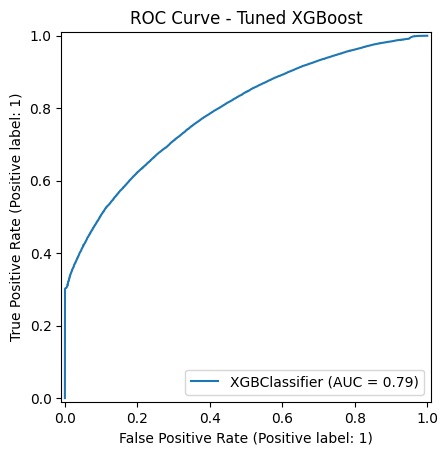

In [75]:
# ======================
# 1) Baseline model (احتفاظ بالجزئية الأصلية)
# ======================
xgb_base = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_base.fit(X_train_selected, y_train_shuffled)
y_pred_base = xgb_base.predict(X_val_selected)
y_prob_base = xgb_base.predict_proba(X_val_selected)[:, 1]

print("=== Before Tuning ===")
print(classification_report(y_val, y_pred_base))
print("ROC AUC:", roc_auc_score(y_val, y_prob_base))

# رسم ROC Curve للموديل قبل الضبط
RocCurveDisplay.from_estimator(xgb_base, X_val_selected, y_val)
plt.title("ROC Curve - Baseline XGBoost")
plt.show()


# ======================
# 2) Hyperparameter tuning
# ======================
param_dist_xgb = {
    'n_estimators': [300, 400, 500],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.03, 0.05],
    'subsample': [0.5, 0.1, 0.7],
    'colsample_bytree': [0.8]
}

tscv = TimeSeriesSplit(n_splits=3)

xgb_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_search.fit(X_train_selected, y_train_shuffled)

print("\nBest XGB params:", xgb_search.best_params_)
print("Best XGB ROC AUC (CV):", xgb_search.best_score_)


# ======================
# 3) Tuned model (dynamic)
# ======================
xgb_tuned = xgb_search.best_estimator_

xgb_tuned.fit(X_train_selected, y_train_shuffled)
y_pred_tuned = xgb_tuned.predict(X_val_selected)
y_prob_tuned = xgb_tuned.predict_proba(X_val_selected)[:, 1]

print("\n=== After Tuning ===")
print(classification_report(y_val, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_val, y_prob_tuned))

# رسم ROC Curve للموديل بعد الضبط
RocCurveDisplay.from_estimator(xgb_tuned, X_val_selected, y_val)
plt.title("ROC Curve - Tuned XGBoost")
plt.show()

### Model Comparison

| Model                    | Accuracy | Precision | Recall | F1-score | ROC AUC |
|--------------------------|---------|-----------|--------|----------|---------|
| XGBoost Before Tuning    | 0.81    | 0.50      | 0.30   | 0.37     | 0.7856  |
| XGBoost After Tuning     | 0.81    | 0.52      | 0.28   | 0.36     | 0.8381  |
| Random Forest            | 0.81    | 0.52      | 0.29   | 0.37     | 0.7920  |
| Decision Tree            | 0.79    | 0.45      | 0.32   | 0.37     | 0.7526  |
| SVM Linear               | 0.81    | 0.82      | 0.04   | 0.07     | 0.7397  |
| K-Nearest Neighbors      | 0.78    | 0.43      | 0.36   | 0.39     | 0.7339  |
| Logistic Regression (L2) | 0.8109  | 0.8146    | 0.9913 | 0.8943   | 0.7455  |

**Best model according to ROC AUC:** XGBoost After Tuning (ROC AUC = 0.8381)


### create some new features with target feature(reorder count) and prepare our dataset to split it

In [67]:
# =============================
# Task B — Regression
# =============================
df['reorder_count'] = df.groupby(['user_id','product_id'])['reordered'].cumsum()

df['total_orders_user'] = df.groupby('user_id')['order_number'].transform('max')

df['total_reorders_product'] = df.groupby('product_id')['reordered'].transform('sum')

df['overall_reorder_rate_product'] = df.groupby('product_id')['reordered'].transform('mean')

target_reg = 'reorder_count'

df_reg = df.drop(columns=['reordered'])

threshold = df_reg['order_number'].quantile(0.8)

train_reg = df_reg[df_reg['order_number'] <= threshold]
val_reg   = df_reg[df_reg['order_number'] > threshold]

X_train_reg = train_reg.drop(columns=[target_reg])
y_train_reg = train_reg[target_reg]

X_val_reg = val_reg.drop(columns=[target_reg])
y_val_reg = val_reg[target_reg]


### basic statistics on target feature

In [ ]:
df["reorder_count"].describe()

,reorder_count
count,1352764.000
mean,0.698
std,0.700
min,0.000
25%,0.000
50%,1.000
75%,1.000
max,9.000


### scale our numeric columns with StandardScaler

In [68]:
numeric_cols = [
    'days_since_prior_order', 'avg_basket_size', 'reorder_ratio',
    'overall_reorder_rate', 'avg_cart_position',
    'avg_reorder_probability_user_product',
    'last_3_orders_mean', 'log_interaction',"total_orders_user",
    "total_reorders_product","overall_reorder_rate_product"
]

scaler = StandardScaler()

X_train_reg[numeric_cols] = scaler.fit_transform(X_train_reg[numeric_cols])

X_val_reg[numeric_cols] = scaler.transform(X_val_reg[numeric_cols])


### take a sample from whole data set

In [69]:
MAX_TRAIN_SIZE = 400000

if len(X_train_reg) > MAX_TRAIN_SIZE:
    X_train_reg, y_train_reg = shuffle(
        X_train_reg, y_train_reg, random_state=42
    )
    X_train_reg = X_train_reg.iloc[:MAX_TRAIN_SIZE]
    y_train_reg = y_train_reg.iloc[:MAX_TRAIN_SIZE]

MAX_VAL_SIZE = 50000

if len(X_val_reg) > MAX_VAL_SIZE:
    X_val_reg, y_val_reg = shuffle(X_val_reg, y_val_reg, random_state=42)
    X_val_reg = X_val_reg.iloc[:MAX_VAL_SIZE]
    y_val_reg = y_val_reg.iloc[:MAX_VAL_SIZE]

print("Final regression validation size:", X_val_reg.shape)
print("Final regression train size:", X_train_reg.shape)


Final regression validation size: (50000, 178)
Final regression train size: (400000, 178)


### drop some columns tha doesnt have mean now

In [70]:
X_train_reg = X_train_reg.drop(columns=['order_id', 'product_id', 'user_id',"product_name"])
X_val_reg   = X_val_reg.drop(columns=['order_id', 'product_id', 'user_id',"product_name"])


### Feature selection to reduce the number of columns: top 15, and later we will do it again to get top 10

=== Top 10 Feature Importances (Regression) ===
avg_reorder_probability_user_product: 0.8382
prior_purchase_count: 0.0608
order_number: 0.0154
overall_reorder_rate: 0.0134
last_3_orders_mean: 0.0068
reorder_ratio: 0.0050
add_to_cart_order: 0.0028
log_interaction: 0.0026
days_since_prior_order: 0.0012
aisle_frozen meals: 0.0008
department_produce: 0.0008
total_orders: 0.0008
department_pantry: 0.0006
aisle_fresh fruits: 0.0006
aisle_yogurt: 0.0006


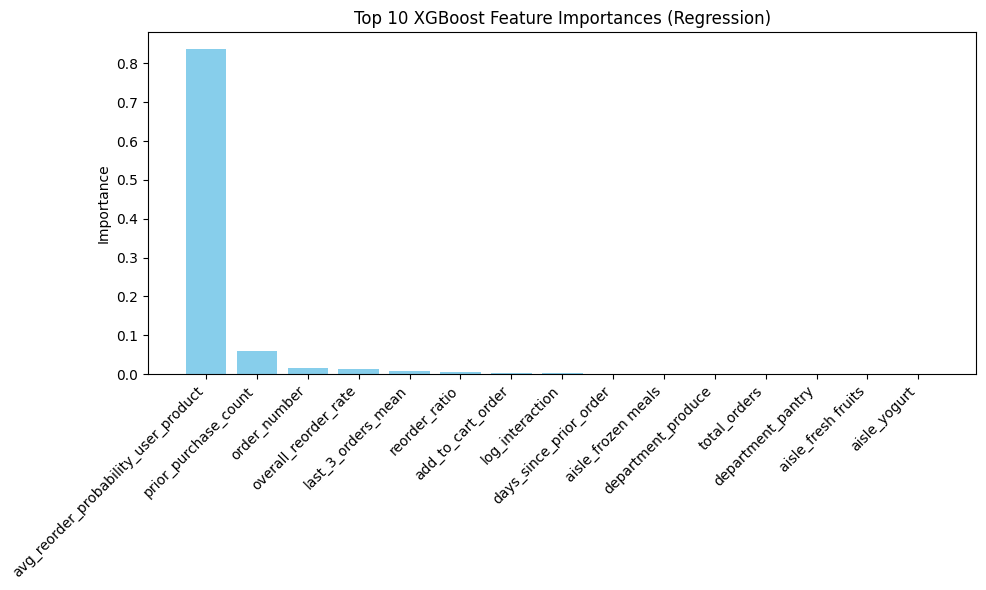

In [71]:
xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.15,
    random_state=42
)

xgb_reg.fit(X_train_reg, y_train_reg)

importances = xgb_reg.feature_importances_
feature_names = X_train_reg.columns

sorted_idx = np.argsort(importances)[::-1]

top_n = 15
top_features = [feature_names[i] for i in sorted_idx[:top_n]]
top_importances = importances[sorted_idx[:top_n]]

print("=== Top 10 Feature Importances (Regression) ===")
for f, imp in zip(top_features, top_importances):
    print(f"{f}: {imp:.4f}")

# رسم بياني
plt.figure(figsize=(10,6))
plt.bar(range(top_n), top_importances, color='skyblue')
plt.xticks(range(top_n), top_features, rotation=45, ha='right')
plt.title("Top 10 XGBoost Feature Importances (Regression)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [72]:
X_train_reg = X_train_reg[top_features]
X_val_reg   = X_val_reg[top_features]

y_train_target = y_train_reg.copy()
y_val_target   = y_val_reg.copy()


### Starting to experiment with the models

=== Lasso Regression ===
MAE: 0.40561928568154765
MSE: 0.29571151288754194
RMSE: 0.5437936307897895
R²: 0.6033005799103559
Adjusted R²: 0.6032212225677225


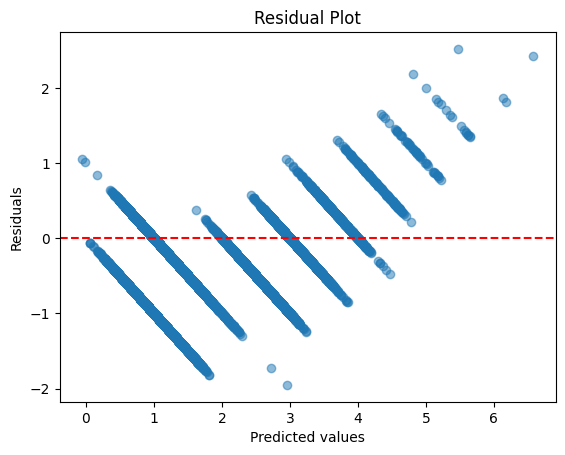

=== Breusch-Pagan Test ===
{'Lagrange multiplier statistic': np.float64(6620.487345659181), 'p-value': np.float64(0.0), 'f-value': np.float64(762.9213001060302), 'f p-value': np.float64(0.0)}


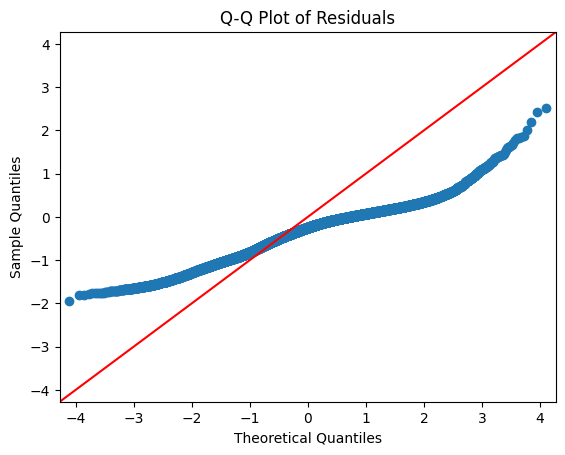

In [ ]:
lasso = Lasso(alpha=0.001, max_iter=5000, random_state=42)
lasso.fit(X_train_reg, y_train_reg)
y_pred = lasso.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("=== Lasso Regression ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)


residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

X_with_const = sm.add_constant(X_val_reg)  # نضيف constant للtest
bp_test = het_breuschpagan(residuals, X_with_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("=== Breusch-Pagan Test ===")
print(dict(zip(labels, bp_test)))

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals")
plt.show()


=== Ridge Regression ===
MAE: 0.4032093093212808
MSE: 0.2923896847151529
RMSE: 0.5407306951849071
R²: 0.6077568396506566
Adjusted R²: 0.60767837375609


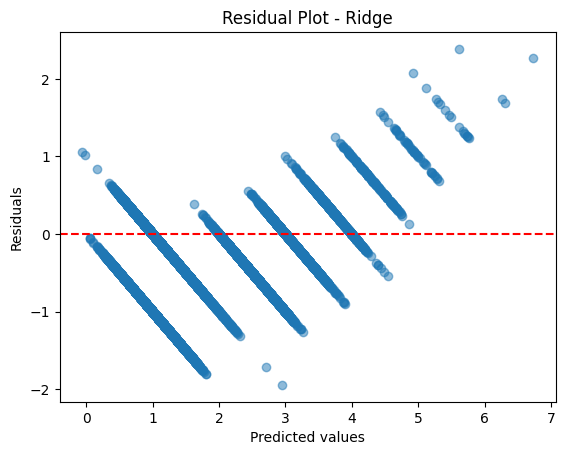

=== Breusch-Pagan Test - Ridge ===
{'Lagrange multiplier statistic': np.float64(6573.978363750105), 'p-value': np.float64(0.0), 'f-value': np.float64(756.7504276080928), 'f p-value': np.float64(0.0)}


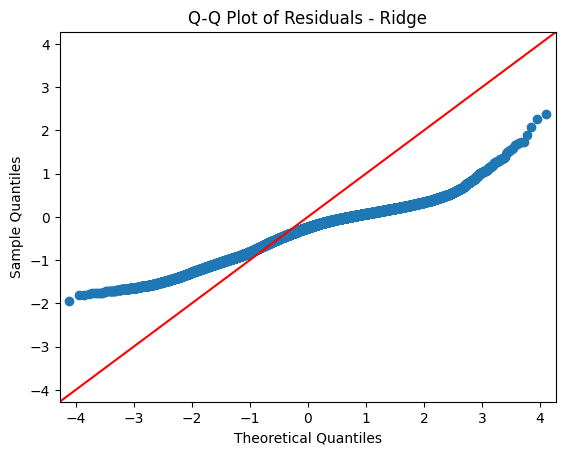

In [ ]:
ridge = Ridge(alpha=1.0, max_iter=5000, random_state=42)
ridge.fit(X_train_reg, y_train_reg)
y_pred = ridge.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2)*(len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("=== Ridge Regression ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)

residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Ridge")
plt.show()

X_with_const = sm.add_constant(X_val_reg)
bp_test = het_breuschpagan(residuals, X_with_const)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("=== Breusch-Pagan Test - Ridge ===")
print(dict(zip(labels, bp_test)))

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals - Ridge")
plt.show()

=== Elastic Net Regression ===
MAE: 0.4049121915090351
MSE: 0.2946782832449685
RMSE: 0.5428427794904971
R²: 0.6046866659508551
Adjusted R²: 0.604607585886431


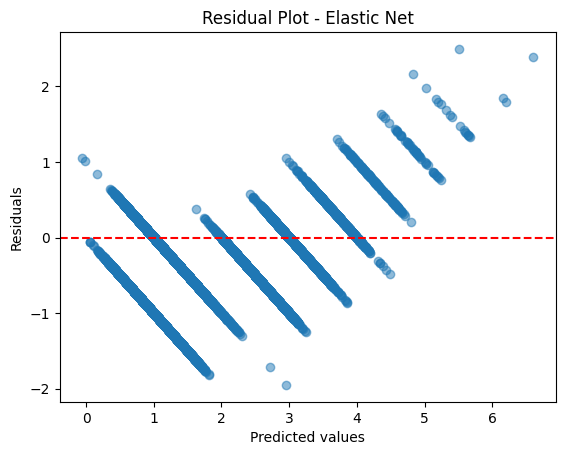

=== Breusch-Pagan Test - Elastic Net ===
{'Lagrange multiplier statistic': np.float64(6585.238173579577), 'p-value': np.float64(0.0), 'f-value': np.float64(758.2431809144201), 'f p-value': np.float64(0.0)}


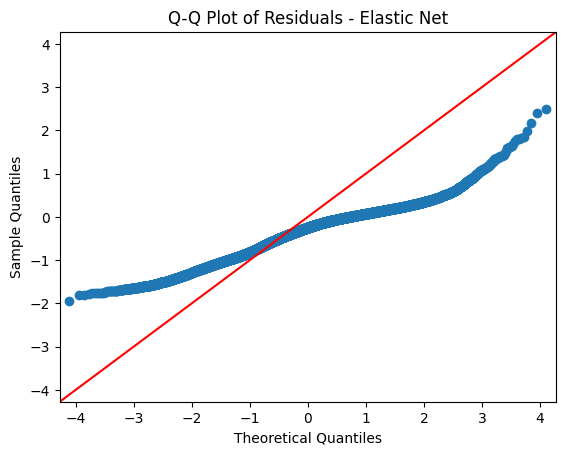

In [ ]:
en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000, random_state=42)
en.fit(X_train_reg, y_train_reg)
y_pred = en.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2)*(len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("=== Elastic Net Regression ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)

residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Elastic Net")
plt.show()

X_with_const = sm.add_constant(X_val_reg)
bp_test = het_breuschpagan(residuals, X_with_const)
print("=== Breusch-Pagan Test - Elastic Net ===")
print(dict(zip(labels, bp_test)))

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals - Elastic Net")
plt.show()


=== KNN Regressor ===
MAE: 0.29305600000000004
MSE: 0.1800352
RMSE: 0.4243055502818694
R²: 0.7584813024750787
Adjusted R²: 0.7584329881064127


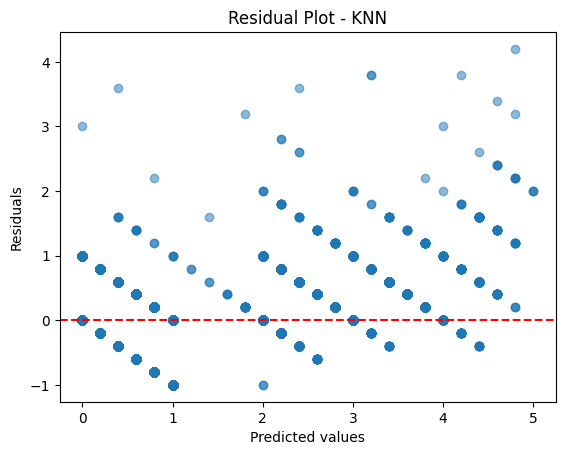

=== Breusch-Pagan Test - KNN ===
{'Lagrange multiplier statistic': np.float64(7413.77105611164), 'p-value': np.float64(0.0), 'f-value': np.float64(870.250807631445), 'f p-value': np.float64(0.0)}


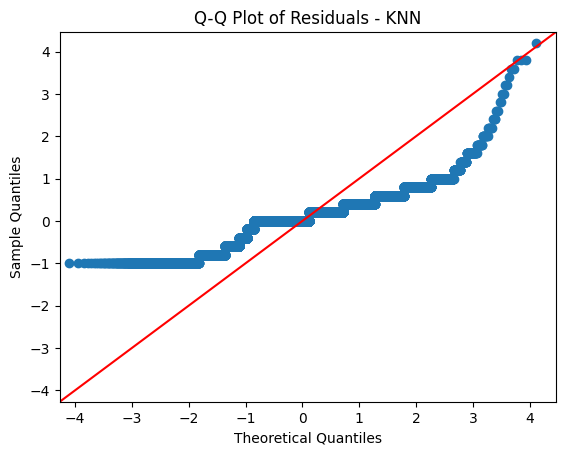

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, metric='minkowski')
knn.fit(X_train_reg, y_train_reg)
y_pred = knn.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2)*(len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("=== KNN Regressor ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)

residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot - KNN")
plt.show()

X_with_const = sm.add_constant(X_val_reg)
bp_test = het_breuschpagan(residuals, X_with_const)
print("=== Breusch-Pagan Test - KNN ===")
print(dict(zip(labels, bp_test)))

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals - KNN")
plt.show()


=== Decision Tree ===
MAE: 0.2598872019549125
MSE: 0.13541381210638354
RMSE: 0.36798615749289204
R²: 0.8183412603378775
Adjusted R²: 0.8183049205952017


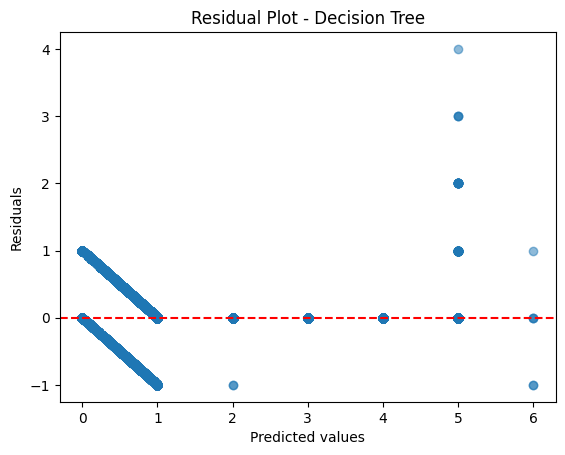

=== Breusch-Pagan Test - Decision Tree ===
{'Lagrange multiplier statistic': np.float64(5457.675329733807), 'p-value': np.float64(0.0), 'f-value': np.float64(612.5044754123135), 'f p-value': np.float64(0.0)}


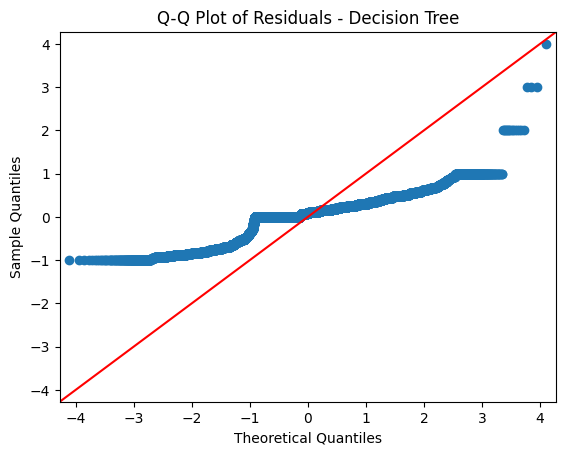

In [ ]:
dt = DecisionTreeRegressor(max_depth=15, random_state=42)
dt.fit(X_train_reg, y_train_reg)
y_pred = dt.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2)*(len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("=== Decision Tree ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)

residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Decision Tree")
plt.show()

X_with_const = sm.add_constant(X_val_reg)
bp_test = het_breuschpagan(residuals, X_with_const)
print("=== Breusch-Pagan Test - Decision Tree ===")
print(dict(zip(labels, bp_test)))

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals - Decision Tree")
plt.show()


=== Random Forest ===
MAE: 0.2686336898890666
MSE: 0.12787644780787952
RMSE: 0.3575981652747669
R²: 0.8284526963689732
Adjusted R²: 0.8284183793585047


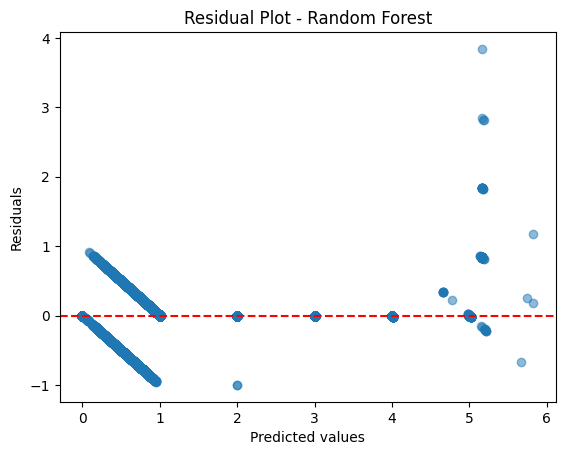

=== Breusch-Pagan Test - Random Forest ===
{'Lagrange multiplier statistic': np.float64(6315.914448849042), 'p-value': np.float64(0.0), 'f-value': np.float64(722.748899055748), 'f p-value': np.float64(0.0)}


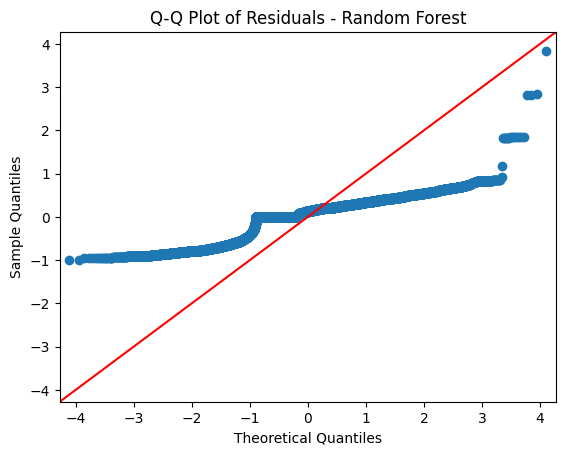

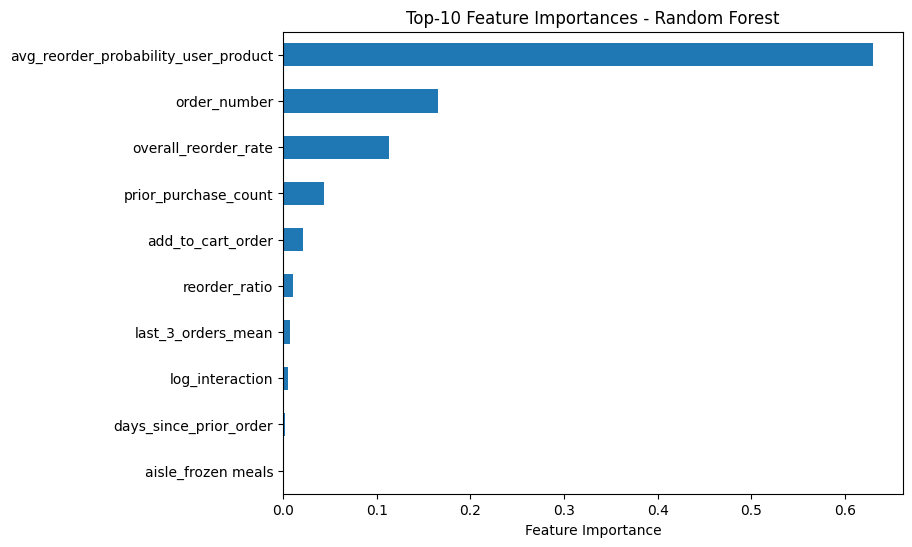

Top-10 features are plausible based on domain knowledge if they correspond to recent user activity, reorder ratio, or average basket size etc.


In [ ]:
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_reg, y_train_reg)
y_pred = rf.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2)*(len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("=== Random Forest ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)

residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Random Forest")
plt.show()

X_with_const = sm.add_constant(X_val_reg)
bp_test = het_breuschpagan(residuals, X_with_const)
print("=== Breusch-Pagan Test - Random Forest ===")
print(dict(zip(labels, bp_test)))

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals - Random Forest")
plt.show()

importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train_reg.columns)
top10 = feat_importances.sort_values(ascending=False)[:10]

top10.plot(kind='barh', figsize=(8,6))
plt.xlabel("Feature Importance")
plt.title("Top-10 Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.show()

print("Top-10 features are plausible based on domain knowledge if they correspond to recent user activity, reorder ratio, or average basket size etc.")


### XGBoost Hyperparameter tuning, evaluation, residual analysis, Breusch-Pagan, Q-Q plot, top-10 feature importance.

=== Before Tuning ===
MAE: 0.2551755905151367
RMSE: 0.35350569821746625
R²: 0.8323566913604736
Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== Best Params ===
{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best CV R²: 0.5670419335365295

=== After Tuning ===
MAE: 0.2594606280326843
MSE: 0.12553465366363525
RMSE: 0.3543086982613259
R²: 0.8315942287445068
Adjusted R²: 0.8315436908410011


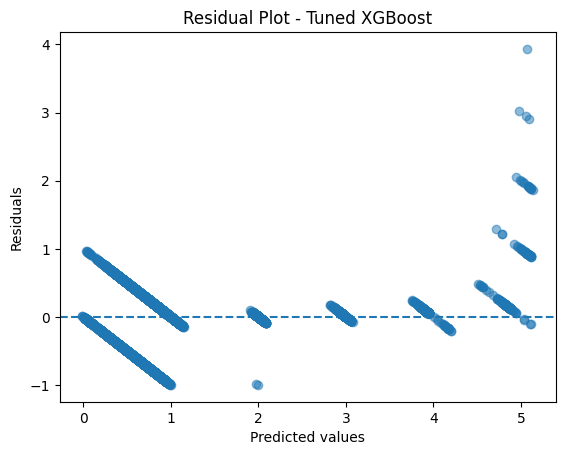


=== Breusch-Pagan Test ===
{'LM Stat': np.float64(5262.063180243143), 'LM p-value': np.float64(0.0), 'F Stat': np.float64(391.94024087571944), 'F p-value': np.float64(0.0)}


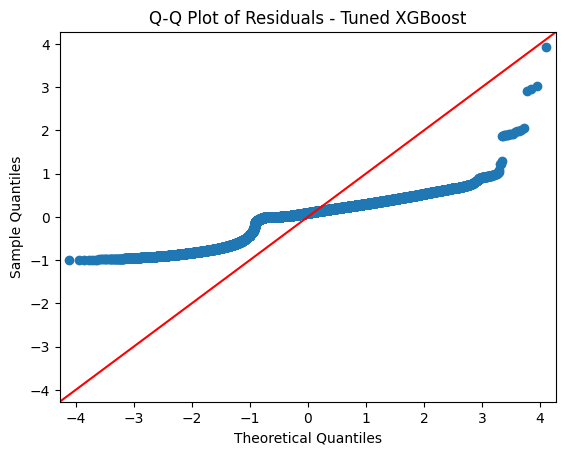

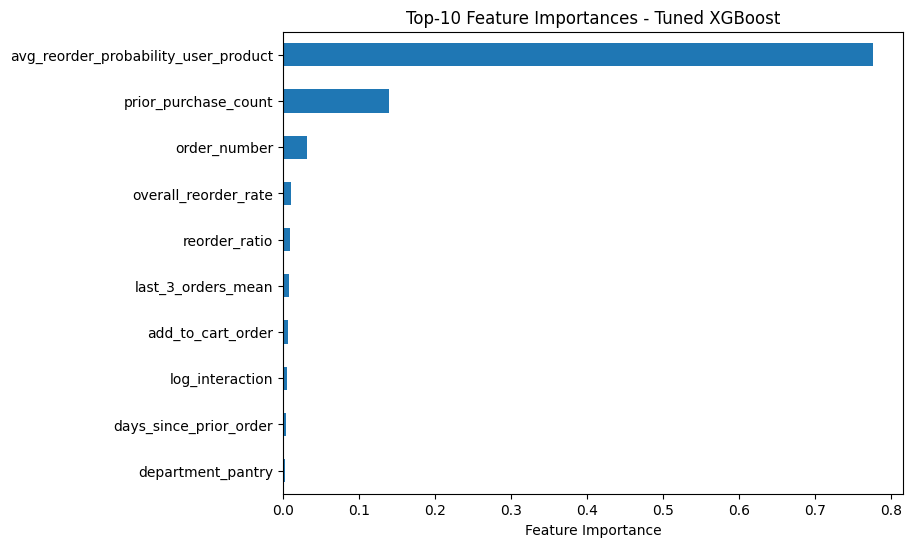

In [76]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======================
# 1) Baseline model
# ======================
xgb_base = XGBRegressor(
    random_state=42,
    eval_metric='rmse'
)

xgb_base.fit(X_train_reg, y_train_reg)
y_pred_base = xgb_base.predict(X_val_reg)

mae_base = mean_absolute_error(y_val_reg, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_val_reg, y_pred_base))
r2_base = r2_score(y_val_reg, y_pred_base)

print("=== Before Tuning ===")
print("MAE:", mae_base)
print("RMSE:", rmse_base)
print("R²:", r2_base)


# ======================
# 2) Hyperparameter tuning
# ======================
param_dist_xgb = {
    'n_estimators': [300, 600, 500],
    'max_depth': [4, 10, 8],
    'learning_rate': [0.01, 0.03, 0.005],
    'subsample': [0.5, 0.4, 1.0],
    'colsample_bytree': [0.7, 0.6, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=10,
    scoring='r2',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train_reg, y_train_reg)

print("\n=== Best Params ===")
print(search.best_params_)
print("Best CV R²:", search.best_score_)


# ======================
# 3) Tuned model (dynamic)
# ======================
xgb_tuned = search.best_estimator_

y_pred = xgb_tuned.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_pred)
mse = mean_squared_error(y_val_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_reg, y_pred)
adj_r2 = 1 - (1 - r2)*(len(y_val_reg)-1)/(len(y_val_reg)-X_val_reg.shape[1]-1)

print("\n=== After Tuning ===")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R²:", r2)
print("Adjusted R²:", adj_r2)


# ======================
# 4) Residual plot
# ======================
residuals = y_val_reg - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot - Tuned XGBoost")
plt.show()


# ======================
# 5) Breusch–Pagan test
# ======================
X_with_const = sm.add_constant(X_val_reg)
bp_test = het_breuschpagan(residuals, X_with_const)
labels = ['LM Stat', 'LM p-value', 'F Stat', 'F p-value']

print("\n=== Breusch-Pagan Test ===")
print(dict(zip(labels, bp_test)))


# ======================
# 6) Q-Q plot
# ======================
sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot of Residuals - Tuned XGBoost")
plt.show()


# ======================
# 7) Feature importance
# ======================
importances = xgb_tuned.feature_importances_
feat_importances = pd.Series(importances, index=X_train_reg.columns)

top10 = feat_importances.sort_values(ascending=False).head(10)

top10.plot(kind='barh', figsize=(8,6))
plt.xlabel("Feature Importance")
plt.title("Top-10 Feature Importances - Tuned XGBoost")
plt.gca().invert_yaxis()
plt.show()


### Regression Model Comparison

| Model                | MAE       | MSE        | RMSE      | R²        | Adjusted R² |
|---------------------|-----------|------------|-----------|-----------|-------------|
| Lasso Regression     | 0.4056    | 0.2957     | 0.5438    | 0.6033    | 0.6032      |
| Ridge Regression     | 0.4032    | 0.2924     | 0.5407    | 0.6078    | 0.6077      |
| Elastic Net Regression | 0.4049  | 0.2947     | 0.5428    | 0.6047    | 0.6046      |
| KNN Regressor        | 0.2931    | 0.1800     | 0.4243    | 0.7585    | 0.7584      |
| Decision Tree        | 0.2599    | 0.1354     | 0.3680    | 0.8183    | 0.8183      |
| Random Forest        | 0.2686    | 0.1279     | 0.3576    | 0.8285    | 0.8284      |
| XGBoost Before Tuning| 0.2552    | 0.831     | 0.3535    | 0.8324    | 0.8315         |
| XGBoost After Tuning | 0.2595    | 0.1255     | 0.3543    | 0.8316    | 0.8315      |

**Best model according to R²:** XGBoost Before Tuning (R² = 0.8324)


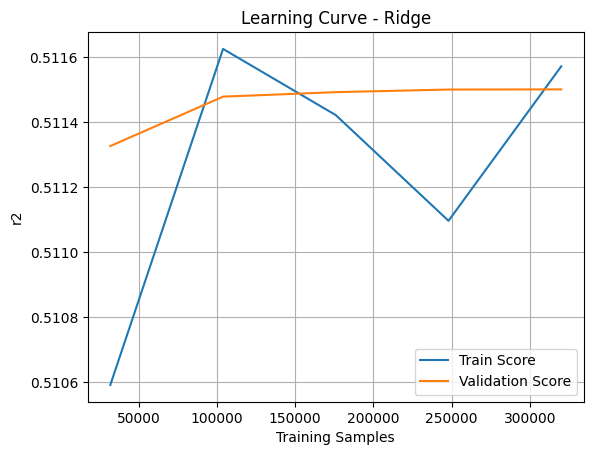

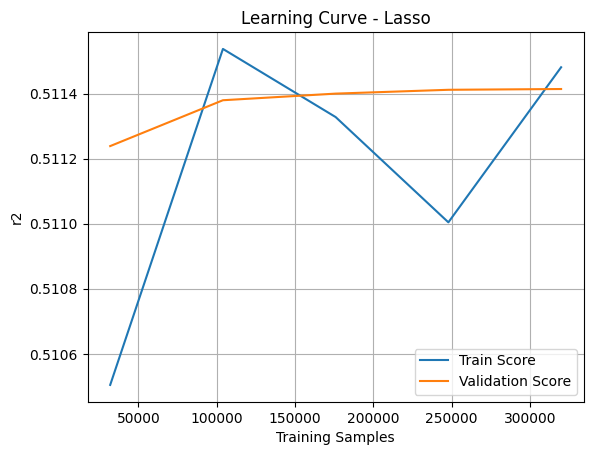

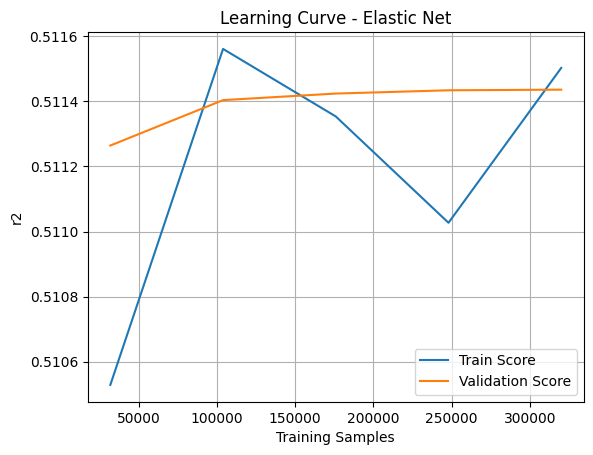

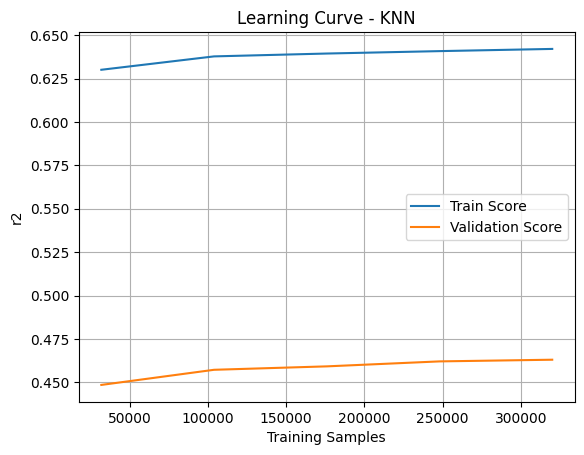

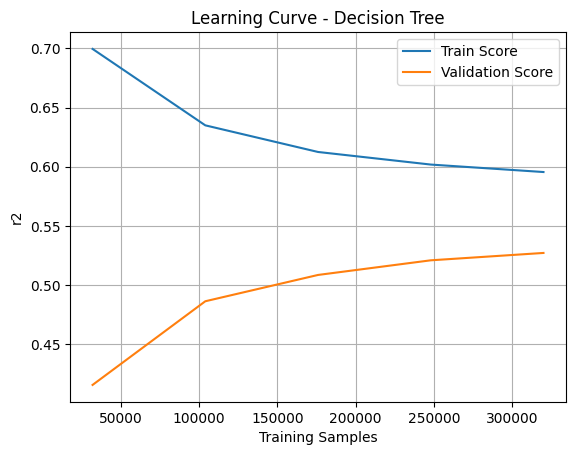

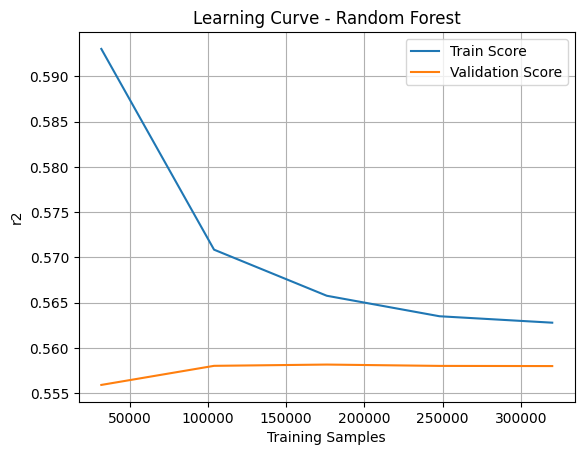

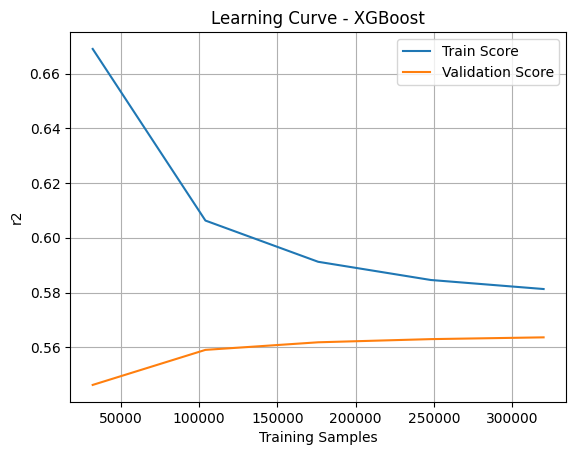

In [ ]:
def plot_learning_curve(model, X, y, title="", cv=5, scoring='r2'):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Train Score')
    plt.plot(train_sizes, val_mean, label='Validation Score')
    plt.xlabel("Training Samples")
    plt.ylabel(scoring)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Ridge
ridge = Ridge(alpha=1.0, max_iter=5000, random_state=42)
plot_learning_curve(ridge, X_train_reg, y_train_reg, title="Learning Curve - Ridge")

# Lasso
lasso = Lasso(alpha=0.001, max_iter=5000, random_state=42)
plot_learning_curve(lasso, X_train_reg, y_train_reg, title="Learning Curve - Lasso")

# Elastic Net
en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000, random_state=42)
plot_learning_curve(en, X_train_reg, y_train_reg, title="Learning Curve - Elastic Net")

# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5, metric='minkowski')
plot_learning_curve(knn, X_train_reg, y_train_reg, title="Learning Curve - KNN")

# Decision Tree
dt = DecisionTreeRegressor(max_depth=15, random_state=42)
plot_learning_curve(dt, X_train_reg, y_train_reg, title="Learning Curve - Decision Tree")

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
plot_learning_curve(rf, X_train_reg, y_train_reg, title="Learning Curve - Random Forest")

# XGBoost
xgb_reg = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.15, random_state=42)
plot_learning_curve(xgb_reg, X_train_reg, y_train_reg, title="Learning Curve - XGBoost")



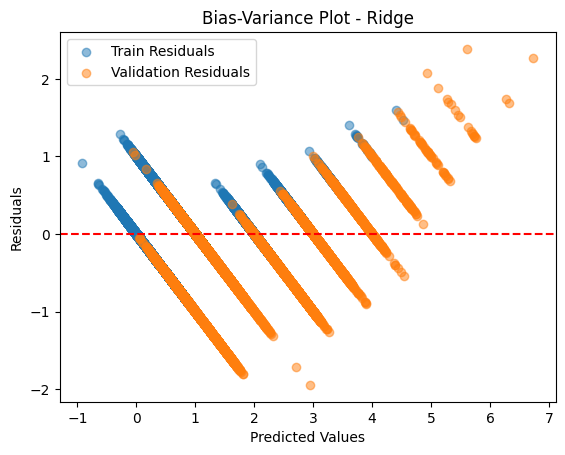

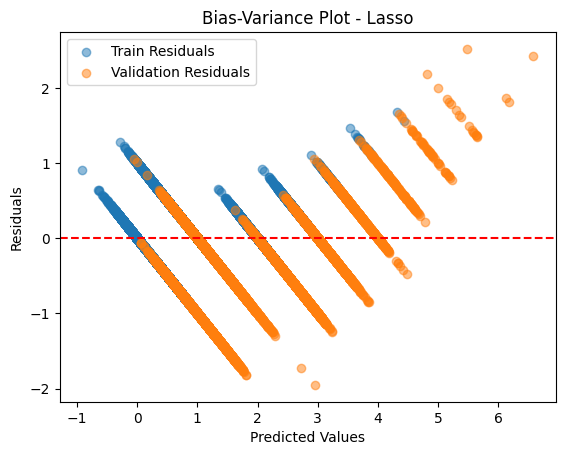

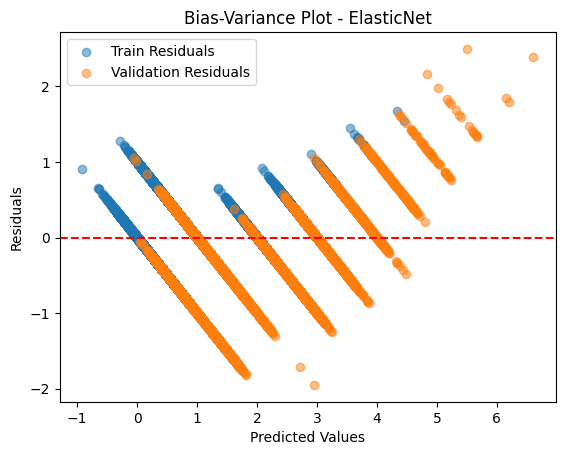

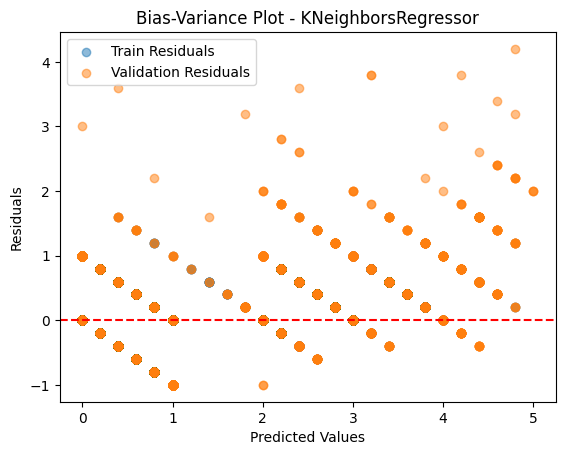

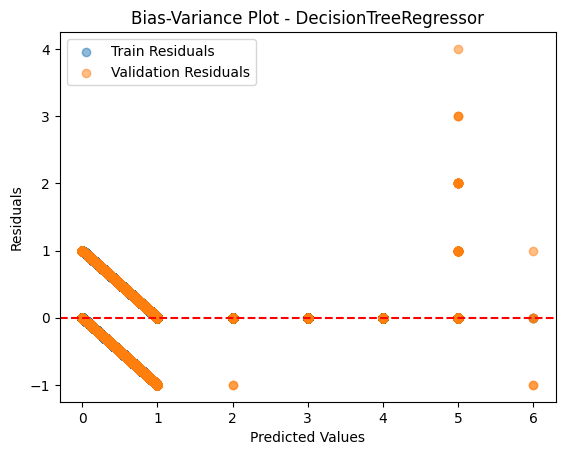

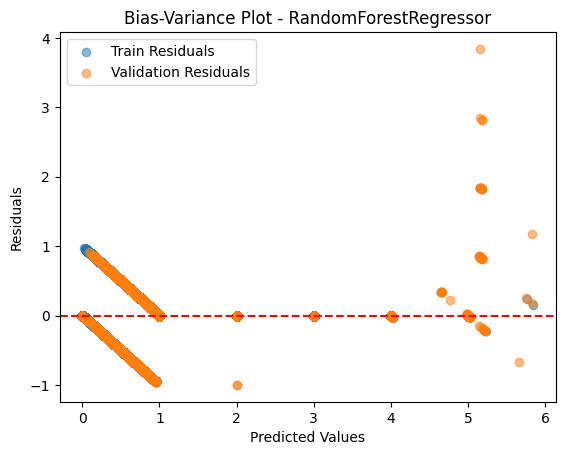

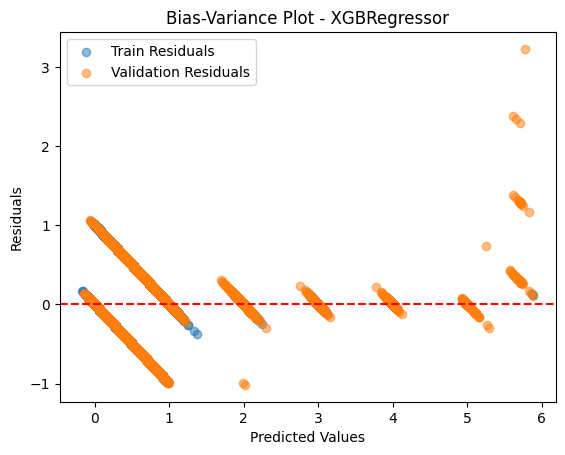

In [ ]:
def bias_variance_plot(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_residuals = y_train - y_train_pred
    val_residuals = y_val - y_val_pred

    plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Train Residuals')
    plt.scatter(y_val_pred, val_residuals, alpha=0.5, label='Validation Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Bias-Variance Plot - {model.__class__.__name__}")
    plt.legend()
    plt.show()

# Ridge
ridge = Ridge(alpha=1.0, max_iter=5000, random_state=42)
bias_variance_plot(ridge, X_train_reg, y_train_reg, X_val_reg, y_val_reg)

# Lasso
lasso = Lasso(alpha=0.001, max_iter=5000, random_state=42)
bias_variance_plot(lasso, X_train_reg, y_train_reg, X_val_reg, y_val_reg)

# Elastic Net
en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=5000, random_state=42)
bias_variance_plot(en, X_train_reg, y_train_reg, X_val_reg, y_val_reg)

# KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5, metric='minkowski')
bias_variance_plot(knn, X_train_reg, y_train_reg, X_val_reg, y_val_reg)

# Decision Tree
dt = DecisionTreeRegressor(max_depth=15, random_state=42)
bias_variance_plot(dt, X_train_reg, y_train_reg, X_val_reg, y_val_reg)

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
bias_variance_plot(rf, X_train_reg, y_train_reg, X_val_reg, y_val_reg)

# XGBoost
xgb_reg = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.15, random_state=42)
bias_variance_plot(xgb_reg, X_train_reg, y_train_reg, X_val_reg, y_val_reg)



In [ ]:
ridge_scores = cross_val_score(ridge, X_train_reg, y_train_reg, cv=5, scoring='r2')
lasso = Lasso(alpha=0.001, max_iter=5000, random_state=42)
lasso_scores = cross_val_score(lasso, X_train_reg, y_train_reg, cv=5, scoring='r2')

t_stat, p_value = ttest_rel(ridge_scores, lasso_scores)
print("Paired t-test Ridge vs Lasso")
print("t-statistic:", t_stat)
print("p-value:", p_value)

w_stat, w_pvalue = wilcoxon(ridge_scores, lasso_scores)
print("Wilcoxon signed-rank test Ridge vs Lasso")
print("Statistic:", w_stat)
print("p-value:", w_pvalue)


Paired t-test Ridge vs Lasso
t-statistic: 2.6120796937364568
p-value: 0.05929030071721164
Wilcoxon signed-rank test Ridge vs Lasso
Statistic: 1.0
p-value: 0.125


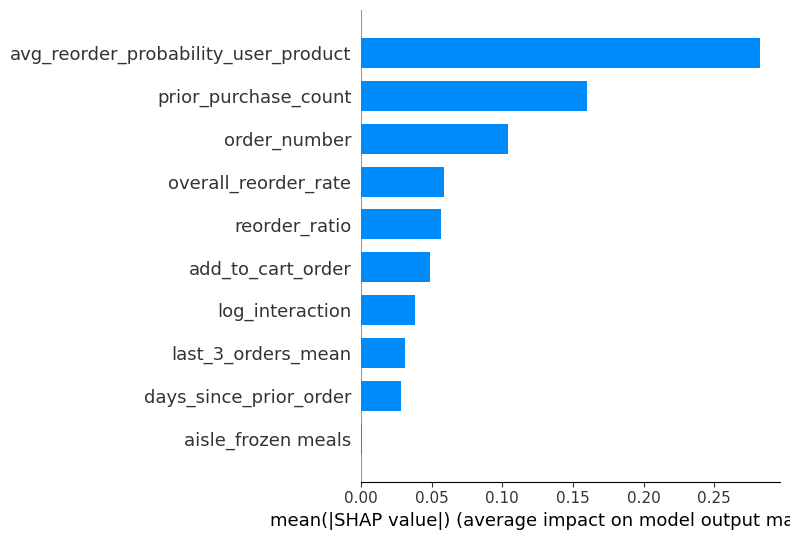

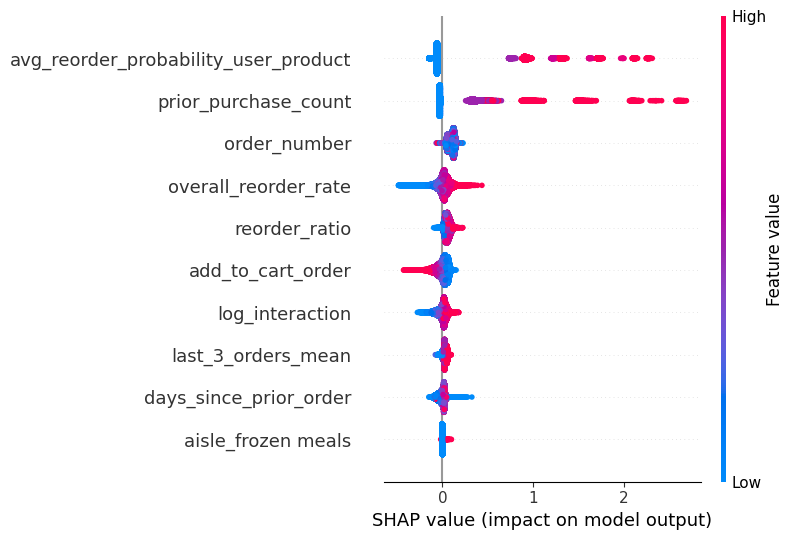

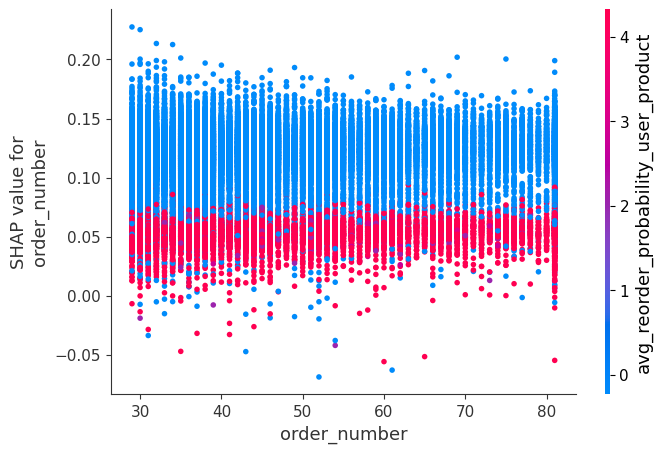

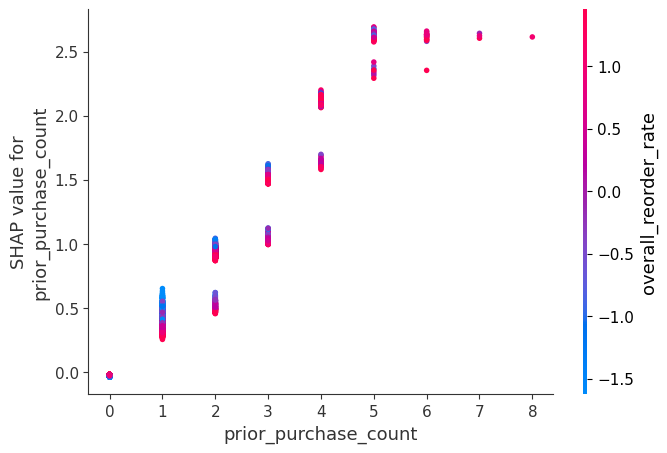

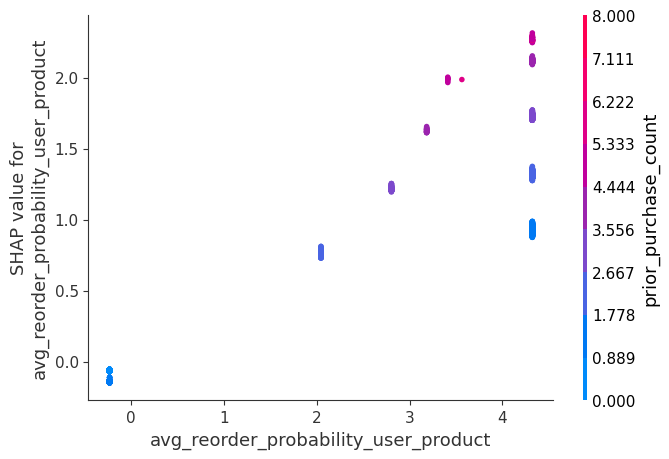

In [ ]:
X_val_reg = X_val_reg.apply(pd.to_numeric, errors='coerce')
X_val_reg = X_val_reg.fillna(0)

explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_val_reg)

shap.summary_plot(shap_values, X_val_reg, plot_type="bar")
shap.summary_plot(shap_values, X_val_reg)

top_features = np.argsort(np.abs(shap_values).mean(0))[-3:]
for f in X_val_reg.columns[top_features]:
    shap.dependence_plot(f, shap_values, X_val_reg)

shap.initjs()
cases = [0, 1, 2]
for i in cases:
    shap.force_plot(
        explainer.expected_value,
        shap_values[i],
        X_val_reg.iloc[i]
    )

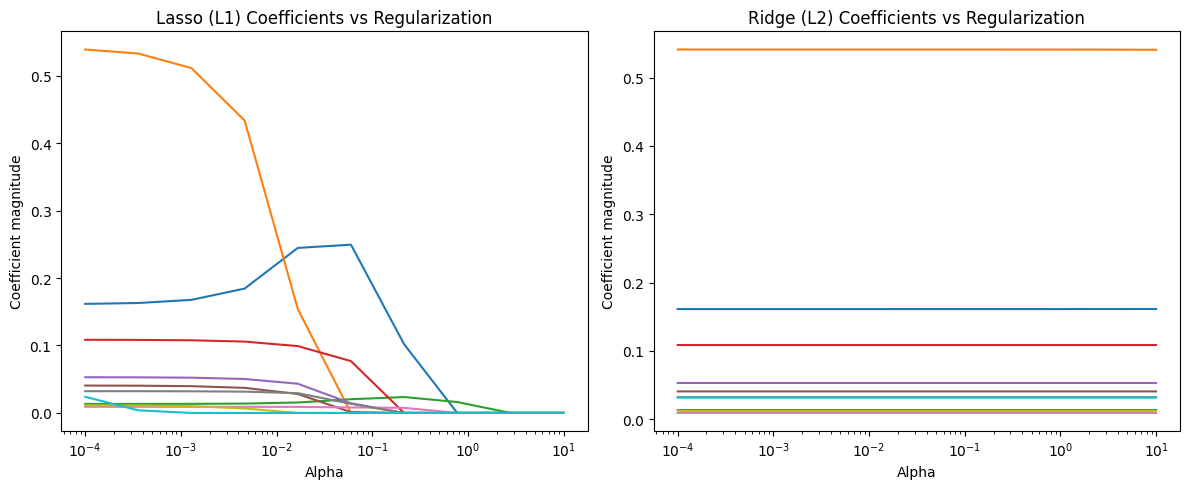

In [ ]:
alphas = np.logspace(-4, 1, 10)
lasso_coefs = []
ridge_coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000, random_state=42)
    lasso.fit(X_train_reg, y_train_reg)
    lasso_coefs.append(np.abs(lasso.coef_))

    ridge = Ridge(alpha=a, max_iter=5000, random_state=42)
    ridge.fit(X_train_reg, y_train_reg)
    ridge_coefs.append(np.abs(ridge.coef_))

lasso_coefs = np.array(lasso_coefs)
ridge_coefs = np.array(ridge_coefs)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for i in range(lasso_coefs.shape[1]):
    plt.plot(alphas, lasso_coefs[:, i], label=X_train_reg.columns[i])
plt.xscale('log')
plt.title("Lasso (L1) Coefficients vs Regularization")
plt.xlabel("Alpha")
plt.ylabel("Coefficient magnitude")

plt.subplot(1,2,2)
for i in range(ridge_coefs.shape[1]):
    plt.plot(alphas, ridge_coefs[:, i], label=X_train_reg.columns[i])
plt.xscale('log')
plt.title("Ridge (L2) Coefficients vs Regularization")
plt.xlabel("Alpha")
plt.ylabel("Coefficient magnitude")
plt.tight_layout()
plt.show()


In [ ]:
X_val_noisy = X_val_reg.copy()
X_train_noisy = X_train_reg.copy()

sigmas = [0.01, 0.05, 0.1]

for sigma in sigmas:
    X_train_noisy = X_train_reg.copy()
    X_val_noisy = X_val_reg.copy()

    for col in X_train_noisy.select_dtypes(include=np.number).columns:
        std_col = X_train_noisy[col].std()
        X_train_noisy[col] += np.random.normal(0, sigma*std_col, size=X_train_noisy.shape[0])
        X_val_noisy[col] += np.random.normal(0, sigma*std_col, size=X_val_noisy.shape[0])

    model = xgb_reg
    y_pred = model.predict(X_val_noisy)
    r2 = r2_score(y_val_reg, y_pred)
    print(f"Gaussian noise σ={sigma}: R² = {r2:.4f}")


Gaussian noise σ=0.01: R² = 0.7667
Gaussian noise σ=0.05: R² = 0.7670
Gaussian noise σ=0.1: R² = 0.7676


In [ ]:
X_train_outliers = X_train_reg.copy()
X_val_outliers = X_val_reg.copy()

frac = 0.01
num_rows = int(frac * X_train_outliers.shape[0])

np.random.seed(42)
for col in X_train_outliers.select_dtypes(include=np.number).columns:
    idx = np.random.choice(X_train_outliers.index, size=num_rows, replace=False)
    X_train_outliers.loc[idx, col] *= 10

    idx_val = np.random.choice(X_val_outliers.index, size=num_rows, replace=False)
    X_val_outliers.loc[idx_val, col] *= 10

y_pred = xgb_reg.predict(X_val_outliers)
r2 = r2_score(y_val_reg, y_pred)
print(f"With 1% outliers: R² = {r2:.4f}")


With 1% outliers: R² = 0.5682


Training fraction 10%: R² = 0.8202
Training fraction 30%: R² = 0.8262
Training fraction 50%: R² = 0.8285
Training fraction 80%: R² = 0.8308


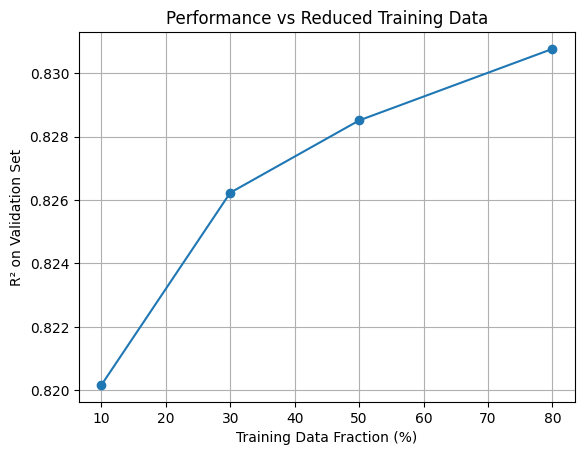

In [ ]:
fractions = [0.1, 0.3, 0.5, 0.8]
results = []

for frac in fractions:
    X_train_frac, _, y_train_frac, _ = train_test_split(
        X_train_reg, y_train_reg, train_size=frac, random_state=42
    )

    model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.15, random_state=42)
    model.fit(X_train_frac, y_train_frac)
    y_pred = model.predict(X_val_reg)
    r2 = r2_score(y_val_reg, y_pred)
    results.append((frac, r2))
    print(f"Training fraction {frac*100:.0f}%: R² = {r2:.4f}")

fractions_percent = [r[0]*100 for r in results]
r2_scores = [r[1] for r in results]
plt.plot(fractions_percent, r2_scores, marker='o')
plt.xlabel("Training Data Fraction (%)")
plt.ylabel("R² on Validation Set")
plt.title("Performance vs Reduced Training Data")
plt.grid(True)
plt.show()
